##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 时间序列预测

<table class="tfo-notebook-buttons" align="left">
  <td> <img src="https://tensorflow.google.cn/images/tf_logo_32px.png"><a target="_blank" href="https://tensorflow.google.cn/tutorials/structured_data/time_series">在 TensorFlow.org 上查看</a> </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/time_series.ipynb"><img src="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/time_series.ipynb">在 Google Colab 中运行</a></td>
  <td> <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png"><a target="_blank" href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/structured_data/time_series.ipynb">在 GitHub 上查看源代码</a> </td>
  <td> <img src="https://tensorflow.google.cn/images/download_logo_32px.png"><a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb">下载笔记本</a> </td>
</table>

本教程是使用 TensorFlow 进行时间序列预测的简介。它构建了几种不同样式的模型，包括卷积神经网络 (CNN) 和循环神经网络 (RNN)。

本教程包括两个主要部分，每个部分包含若干小节：

- 预测单个时间步骤：
    - 单个特征。
    - 所有特征。
- 预测多个时间步骤：
    - 单次：一次做出所有预测。
    - 自回归：一次做出一个预测，并将输出馈送回模型。

## 安装

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2023-11-08 00:53:03.106712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 00:53:03.106761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 00:53:03.108388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 天气数据集

本教程使用由<a href="https://www.bgc-jena.mpg.de/wetter/" class="external">马克斯·普朗克生物地球化学研究所</a>记录的<a href="https://www.bgc-jena.mpg.de" class="external">[天气时间序列数据集</a>。

此数据集包含了 14 个不同特征，例如气温、气压和湿度。自 2003 年起，这些数据每 10 分钟就会被收集一次。为了提高效率，您将仅使用 2009 至 2016 年之间收集的数据。数据集的这一部分由 François Chollet 为他的 [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) 一书所准备。

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

    8192/13568290 [..............................] - ETA: 0s

 7749632/13568290 [================>.............] - ETA: 0s

13568290/13568290 [==============================] - 0s 0us/step


本教程仅处理**每小时预测**，因此先从 10 分钟间隔到 1 小时对数据进行下采样：

In [4]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

让我们看一下数据。下面是前几行：

In [5]:
df.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
5     996.50     -8.05    265.38        -8.78    94.4          3.33   
11    996.62     -8.88    264.54        -9.77    93.2          3.12   
17    996.84     -8.81    264.59        -9.66    93.5          3.13   
23    996.99     -9.05    264.34       -10.02    92.6          3.07   
29    997.46     -9.63    263.72       -10.65    92.2          2.94   

    VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
5           3.14          0.19       1.96             3.15       1307.86   
11          2.90          0.21       1.81             2.91       1312.25   
17          2.93          0.20       1.83             2.94       1312.18   
23          2.85          0.23       1.78             2.85       1313.61   
29          2.71          0.23       1.69             2.71       1317.19   

    wv (m/s)  max. wv (m/s)  wd (deg)  
5       0.21           0.63     192.7  
11      0.25           0.63     190.3  
17      0.18           0.63     167.2  
23      0.10           0.38     240.0  
29      0.40           0.88     157.0

下面是一些特征随时间的演变：

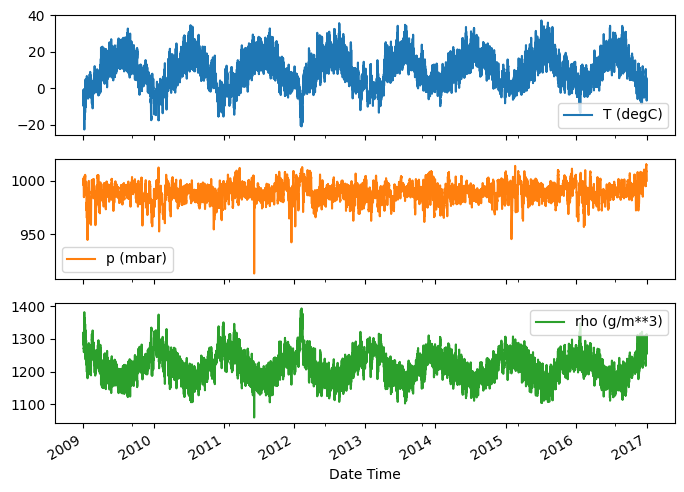

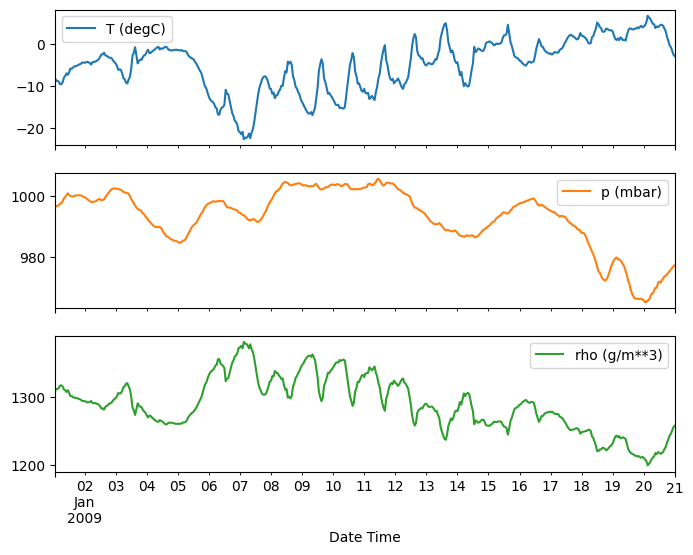

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### 检查和清理

接下来，看一下数据集的统计数据：

In [7]:
df.describe().transpose()

count         mean        std      min      25%      50%  \
p (mbar)         70091.0   989.212842   8.358886   913.60   984.20   989.57   
T (degC)         70091.0     9.450482   8.423384   -22.76     3.35     9.41   
Tpot (K)         70091.0   283.493086   8.504424   250.85   277.44   283.46   
Tdew (degC)      70091.0     4.956471   6.730081   -24.80     0.24     5.21   
rh (%)           70091.0    76.009788  16.474920    13.88    65.21    79.30   
VPmax (mbar)     70091.0    13.576576   7.739883     0.97     7.77    11.82   
VPact (mbar)     70091.0     9.533968   4.183658     0.81     6.22     8.86   
VPdef (mbar)     70091.0     4.042536   4.898549     0.00     0.87     2.19   
sh (g/kg)        70091.0     6.022560   2.655812     0.51     3.92     5.59   
H2OC (mmol/mol)  70091.0     9.640437   4.234862     0.81     6.29     8.96   
rho (g/m**3)     70091.0  1216.061232  39.974263  1059.45  1187.47  1213.80   
wv (m/s)         70091.0     1.702567  65.447512 -9999.00     0.99     1.76   
max. wv (m/s)    70091.0     2.963041  75.597657 -9999.00     1.76     2.98   
wd (deg)         70091.0   174.789095  86.619431     0.00   125.30   198.10   

                      75%      max  
p (mbar)          994.720  1015.29  
T (degC)           15.480    37.28  
Tpot (K)          289.530   311.21  
Tdew (degC)        10.080    23.06  
rh (%)             89.400   100.00  
VPmax (mbar)       17.610    63.77  
VPact (mbar)       12.360    28.25  
VPdef (mbar)        5.300    46.01  
sh (g/kg)           7.800    18.07  
H2OC (mmol/mol)    12.490    28.74  
rho (g/m**3)     1242.765  1393.54  
wv (m/s)            2.860    14.01  
max. wv (m/s)       4.740    23.50  
wd (deg)          234.000   360.00

#### 风速

值得注意的一件事是风速 (`wv (m/s)`) 的 `min` 值和最大值 (`max. wv (m/s)`) 列。这个 `-9999` 可能是错误的。

有一个单独的风向列，因此速度应大于零 (`>=0`)。将其替换为零：

In [8]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### 特征工程

在潜心构建模型之前，务必了解数据并确保传递格式正确的数据。

#### 风

数据的最后一列 `wd (deg)` 以度为单位给出了风向。角度不是很好的模型输入：360° 和 0° 应该会彼此接近，并平滑换行。如果不吹风，方向则无关紧要。

现在，风数据的分布状况如下：

Text(0, 0.5, 'Wind Velocity [m/s]')

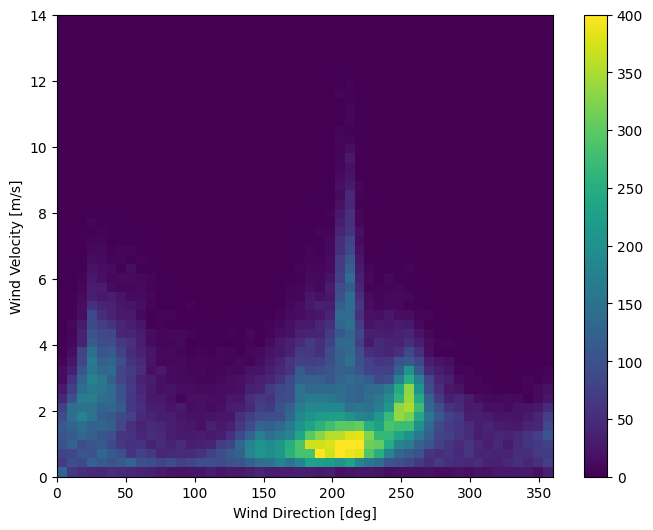

In [9]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

但是，如果将风向和风速列转换为风**向量**，模型将更容易解释：

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

模型正确解释风向量的分布要简单得多：

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

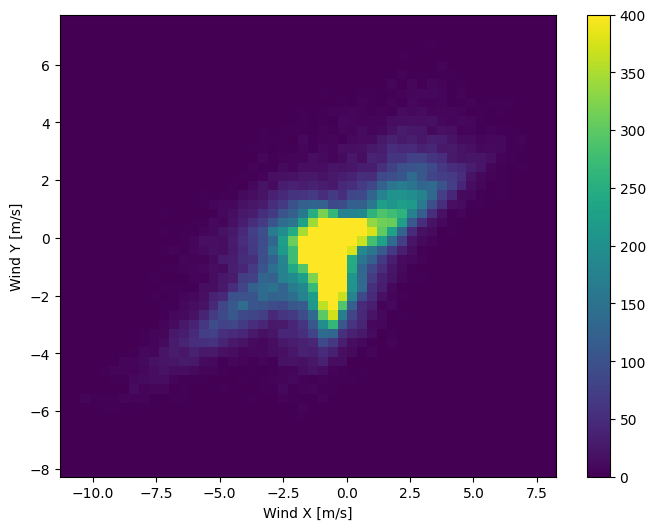

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### 时间

同样，`Date Time` 列非常有用，但不是以这种字符串形式。首先将其转换为秒：

In [12]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

与风向类似，以秒为单位的时间不是有用的模型输入。作为天气数据，它有清晰的每日和每年周期性。可以通过多种方式处理周期性。

您可以通过使用正弦和余弦变换为清晰的“一天中的时间”和“一年中的时间”信号来获得可用的信号：

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

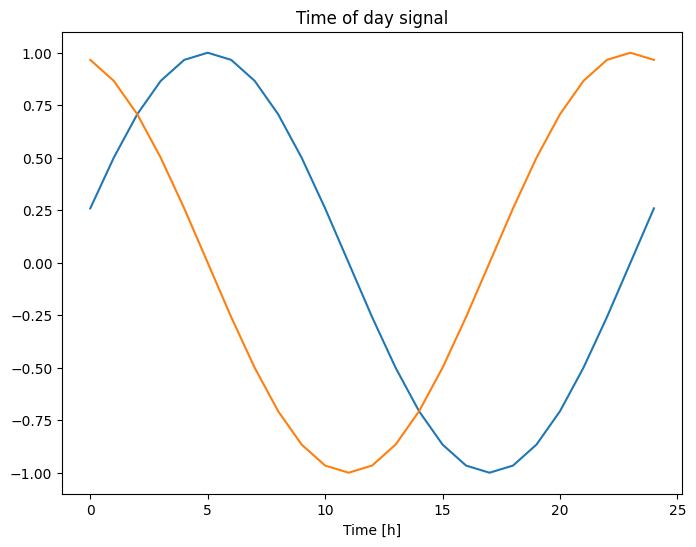

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

这使模型能够访问最重要的频率特征。在这种情况下，您提前知道了哪些频率很重要。

如果您没有该信息，则可以通过使用<a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">快速傅里叶变换</a>提取特征来确定哪些频率重要。要检验假设，下面是温度随时间变化的 `tf.signal.rfft`。请注意 `1/year` 和 `1/day` 附近频率的明显峰值：


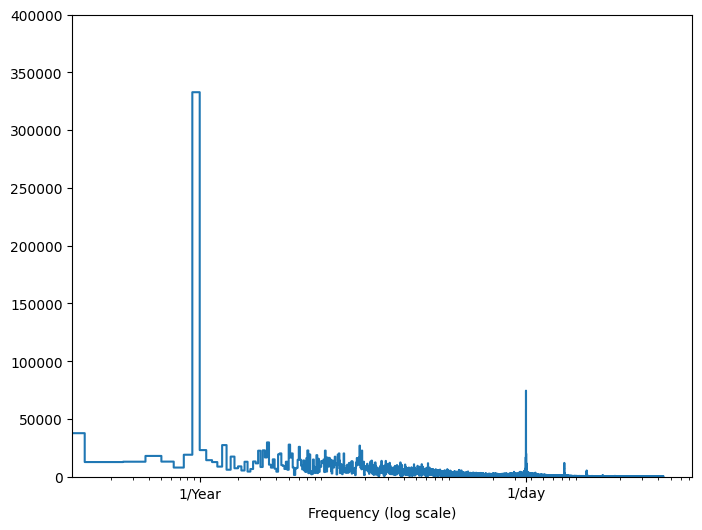

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### 拆分数据

您将使用 `(70%, 20%, 10%)` 拆分出训练集、验证集和测试集。请注意，在拆分前数据**没有**随机打乱顺序。这有两个原因：

1. 确保仍然可以将数据切入连续样本的窗口。
2. 确保训练后在收集的数据上对模型进行评估，验证/测试结果更加真实。

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### 归一化数据

在训练神经网络之前缩放特征很重要。归一化是进行此类缩放的常见方式：减去平均值，然后除以每个特征的标准偏差。

平均值和标准偏差应仅使用训练数据进行计算，从而使模型无法访问验证集和测试集中的值。

有待商榷的是：模型在训练时不应访问训练集中的未来值，以及应该使用移动平均数来进行此类规范化。这不是本教程的重点，验证集和测试集会确保我们获得（某种程度上）可靠的指标。因此，为了简单起见，本教程使用的是简单平均数。

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

现在看一下这些特征的分布。部分特征的尾部确实很长，但没有类似 `-9999` 风速值的明显错误。

/tmpfs/tmp/ipykernel_919717/3214313372.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


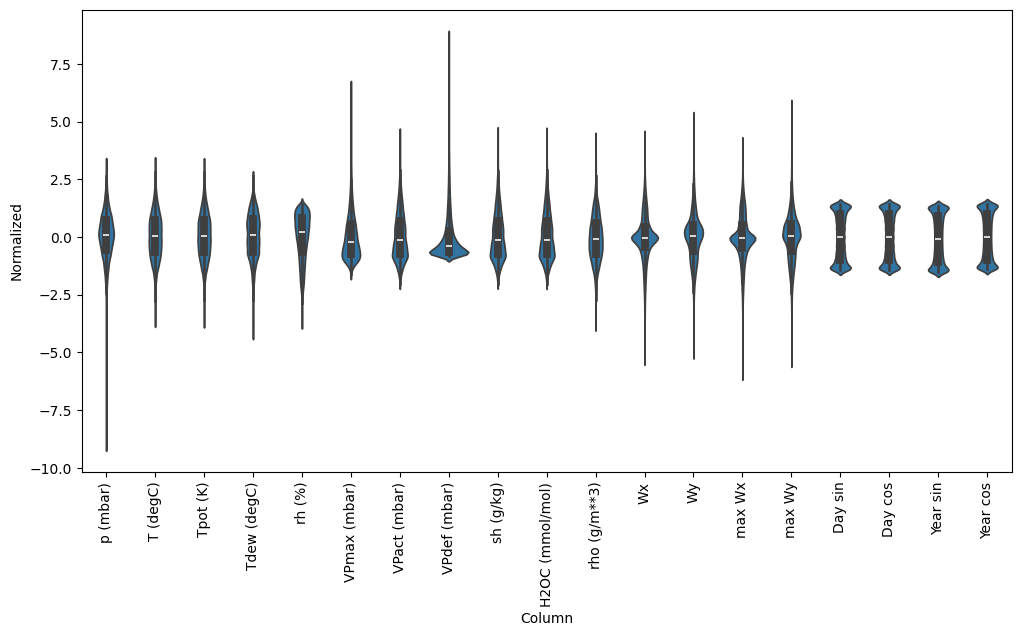

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## 数据窗口化

本教程中的模型将基于来自数据连续样本的窗口进行一组预测。

输入窗口的主要特征包括：

- 输入和标签窗口的宽度（时间步骤数量）。
- 它们之间的时间偏移量。
- 用作输入、标签或两者的特征。

本教程构建了各种模型（包括线性、DNN、CNN 和 RNN 模型），并将它们用于以下两种情况：

- *单输出*和*多输出*预测。
- *单时间步骤*和*多时间步骤*预测。

本部分重点介绍实现数据窗口化，以便将其重用到上述所有模型。


根据任务和模型类型，您可能需要生成各种数据窗口。下面是一些示例：

1. 例如，要在给定 24 小时历史记录的情况下对未来 24 小时作出一次预测，可以定义如下窗口：

![对未来 24 小时的一次预测。](images/raw_window_24h.png)

1. 给定 6 小时的历史记录，对未来 1 小时作出一次预测的模型将需要类似下面的窗口：

![对未来 1 小时的一次预测。](images/raw_window_1h.png)

本部分的剩余内容会定义 `WindowGenerator` 类。此类可以：

1. 处理如上图所示的索引和偏移量。
2. 将特征窗口拆分为 `(features, labels)` 对。
3. 绘制结果窗口的内容。
4. 使用 `tf.data.Dataset` 从训练、评估和测试数据高效生成这些窗口的批次。

### 1. 索引和偏移量

首先创建 `WindowGenerator` 类。`__init__` 方法包含输入和标签索引的所有必要逻辑。

它还将训练、评估和测试 DataFrame 作为输出。这些稍后将被转换为窗口的 `tf.data.Dataset`。

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

下面是创建本部分开头图表中所示的两个窗口的代码：

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. 拆分

给定一个连续输入的列表，`split_window` 方法会将它们转换为输入窗口和标签窗口。

您之前定义的示例 `w2` 将按以下方式拆分：

![初始窗口都是连续的样本，这会将其拆分成一个（输入，标签）对](images/split_window.png)

此图不显示数据的 `features` 轴，但此 `split_window` 函数还会处理 `label_columns`，因此可以将其用于单输出和多输出样本。

In [22]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

试试以下代码：

In [23]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


通常，TensorFlow 中的数据会被打包到数组中，其中最外层索引是交叉样本（“批次”维度）。中间索引是“时间”和“空间”（宽度、高度）维度。最内层索引是特征。

上面的代码使用了三个 7 时间步骤窗口的批次，每个时间步骤有 19 个特征。它将其拆分成一个 6 时间步骤的批次、19 个特征输入和一个 1 时间步骤 1 特征的标签。该标签仅有一个特征，因为 `WindowGenerator` 已使用 `label_columns=['T (degC)']` 进行了初始化。最初，本教程将构建预测单个输出标签的模型。

### 3. 绘图

下面是一个绘图方法，可以对拆分窗口进行简单可视化：

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

此绘图根据项目引用的时间来对齐输入、标签和（稍后的）预测：

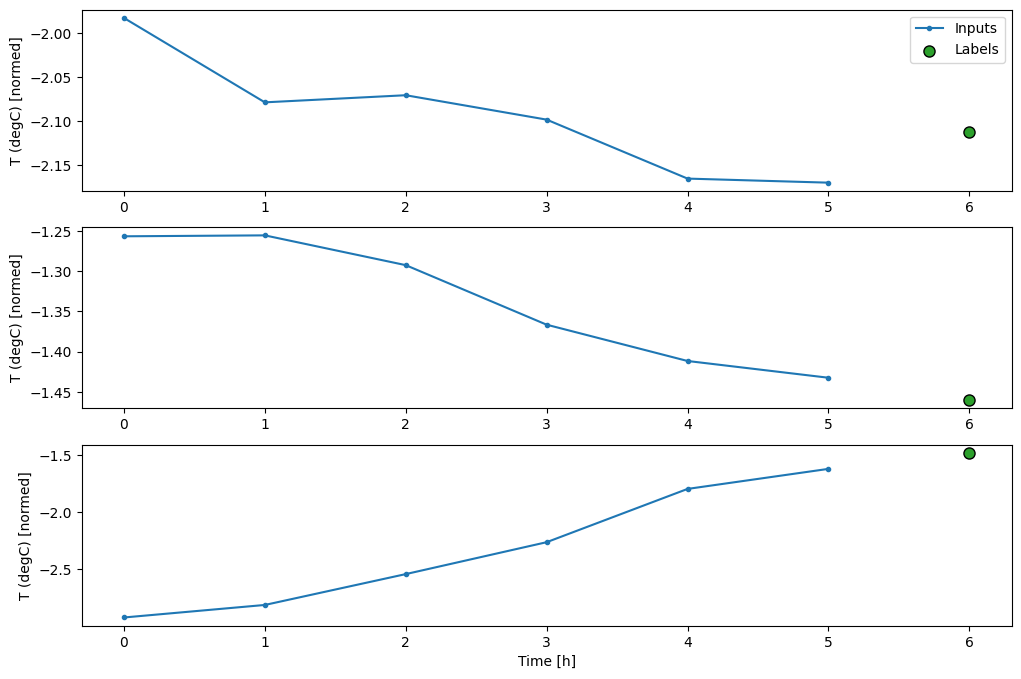

In [26]:
w2.plot()

您可以绘制其他列，但是样本窗口 `w2` 配置仅包含 `T (degC)` 列的标签。

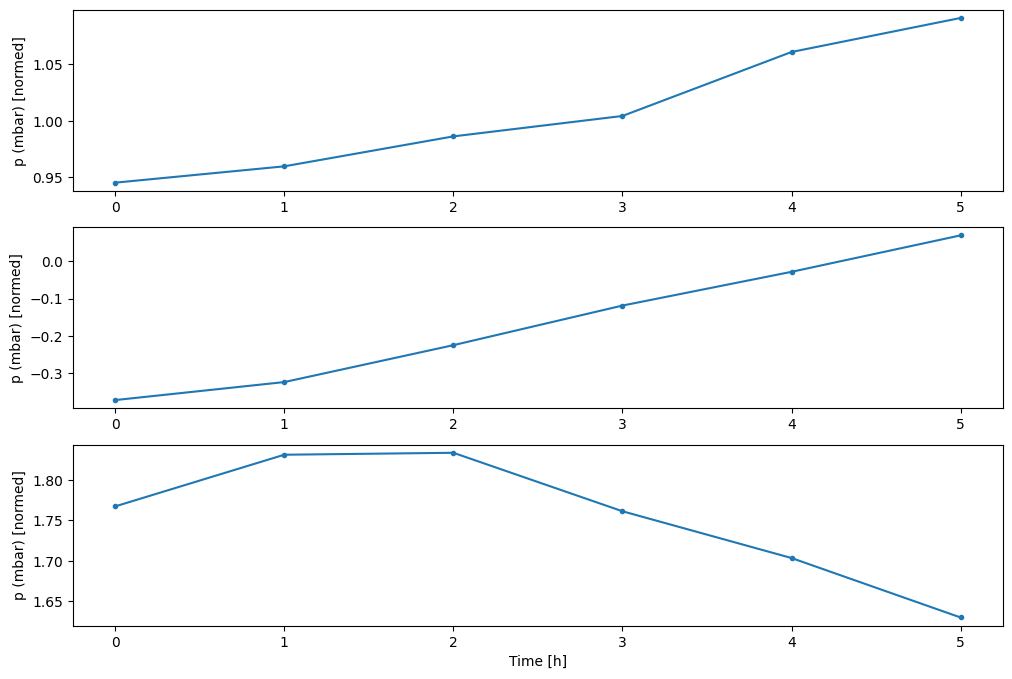

In [27]:
w2.plot(plot_col='p (mbar)')

### 4. 创建 `tf.data.Dataset`

最后，此 `make_dataset` 方法将获取时间序列 DataFrame 并使用 `tf.keras.utils.timeseries_dataset_from_array` 函数将其转换为 `(input_window, label_window)` 对的 `tf.data.Dataset`。

In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

`WindowGenerator` 对象包含训练、验证和测试数据。

使用您之前定义的 `make_dataset` 方法添加属性以作为 `tf.data.Dataset` 访问它们。此外，添加一个标准样本批次以便于访问和绘图：

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

现在，`WindowGenerator` 对象允许您访问 `tf.data.Dataset` 对象，因此您可以轻松迭代数据。

`Dataset.element_spec` 属性会告诉您数据集元素的结构、数据类型和形状。

In [30]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

在 `Dataset` 上进行迭代会产生具体批次：

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## 单步模型

基于此类数据能够构建的最简单模型，能够仅根据当前条件预测单个特征的值，即未来的一个时间步骤（1 小时）。

因此，从构建模型开始，预测未来 1 小时的 `T (degC)` 值。

![预测下一个时间步骤](images/narrow_window.png)

配置 `WindowGenerator` 对象以生成下列单步 `(input, label)` 对：

In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

`window` 会根据训练、验证和测试集创建 `tf.data.Datasets`，使您可以轻松迭代数据批次。


In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### 基线

在构建可训练模型之前，最好将性能基线作为与以后更复杂的模型进行比较的点。

第一个任务是在给定所有特征的当前值的情况下，预测未来 1 小时的温度。当前值包括当前温度。

因此，从仅返回当前温度作为预测值的模型开始，预测“无变化”。这是一个合理的基线，因为温度变化缓慢。当然，如果您对更远的未来进行预测，此基线的效果就不那么好了。

![将输入发送到输出](https://github.com/tensorflow/docs-l10n/blob/master/site/en-snapshot/tutorials/structured_data/images/baseline.png?raw=true)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

实例化并评估此模型：

In [35]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 4:12 - loss: 0.0133 - mean_absolute_error: 0.0845

 27/439 [>.............................] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.0752  

 54/439 [==>...........................] - ETA: 0s - loss: 0.0122 - mean_absolute_error: 0.0773

 82/439 [====>.........................] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0784

111/439 [======>.......................] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.0789

140/439 [========>.....................] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0784

168/439 [==========>...................] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0785

196/439 [============>.................] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0781

224/439 [==============>...............] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0785

252/439 [================>.............] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0784

280/439 [==================>...........] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.0782

309/439 [====================>.........] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0786

338/439 [======================>.......] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0784

366/439 [========================>.....] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0783

395/439 [=========================>....] - ETA: 0s - loss: 0.0128 - mean_absolute_error: 0.0781

425/439 [============================>.] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.0786

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


上面的代码打印了一些性能指标，但这些指标并没有使您对模型的运行情况有所了解。

`WindowGenerator` 有一种绘制方法，但只有一个样本，绘图不是很有趣。

因此，创建一个更宽的 `WindowGenerator` 来一次生成包含 24 小时连续输入和标签的窗口。新的 `wide_window` 变量不会更改模型的运算方式。模型仍会根据单个输入时间步骤对未来 1 小时进行预测。这里 `time` 轴的作用类似于 `batch` 轴：每个预测都是独立进行的，时间步骤之间没有交互：

In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

此扩展窗口可以直接传递到相同的 `baseline` 模型，而无需修改任何代码。能做到这一点是因为输入和标签具有相同数量的时间步骤，并且基线只是将输入转发至输出：

![对未来 1 小时进行一次预测，每小时一次。](images/last_window.png)

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


通过绘制基线模型的预测值，可以注意到只是标签向右移动了 1 小时：

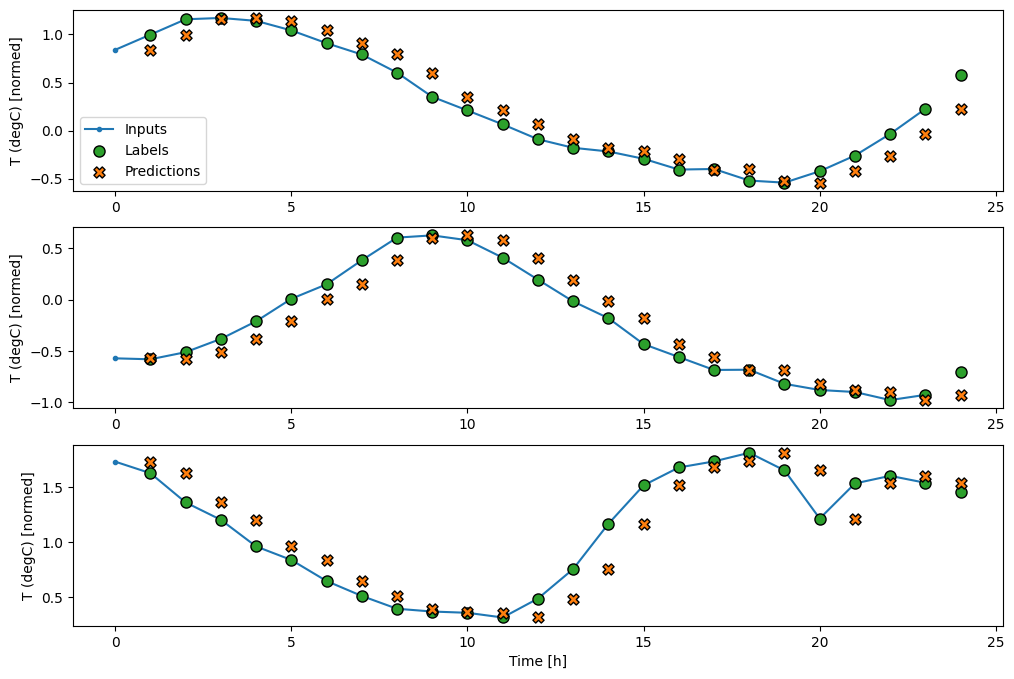

In [38]:
wide_window.plot(baseline)

在上面三个样本的绘图中，单步模型运行了 24 个小时。这需要一些解释：

- 蓝色的 `Inputs` 行显示每个时间步骤的输入温度。模型会接收所有特征，而该绘图仅显示温度。
- 绿色的 `Labels` 点显示目标预测值。这些点在预测时间，而不是输入时间显示。这就是为什么标签范围相对于输入移动了 1 步。
- 橙色的 `Predictions` 叉是模型针对每个输出时间步骤的预测。如果模型能够进行完美预测，则预测值将直接落在 `Labels` 上。

### 线性模型

可以应用于此任务的最简单的**可训练**模型是在输入和输出之间插入线性转换。在这种情况下，时间步骤的输出仅取决于该步骤：

![单步预测](images/narrow_window.png)

没有设置 `activation` 的 `tf.keras.layers.Dense` 层是线性模型。层仅会将数据的最后一个轴从 `(batch, time, inputs)` 转换为 `(batch, time, units)`；它会单独应用于 `batch` 和 `time` 轴的每个条目。

In [39]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [40]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


本教程训练许多模型，因此将训练过程打包到一个函数中：

In [41]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

训练模型并评估其性能：

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 19:01 - loss: 1.1497 - mean_absolute_error: 0.8629

  20/1534 [..............................] - ETA: 3s - loss: 1.2007 - mean_absolute_error: 0.8521   

I0000 00:00:1699404805.567571  919923 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  40/1534 [..............................] - ETA: 3s - loss: 1.0984 - mean_absolute_error: 0.8223

  60/1534 [>.............................] - ETA: 3s - loss: 1.0066 - mean_absolute_error: 0.7853

  81/1534 [>.............................] - ETA: 3s - loss: 0.9190 - mean_absolute_error: 0.7492

 102/1534 [>.............................] - ETA: 3s - loss: 0.8709 - mean_absolute_error: 0.7295

 123/1534 [=>............................] - ETA: 3s - loss: 0.8137 - mean_absolute_error: 0.7049

 143/1534 [=>............................] - ETA: 3s - loss: 0.7835 - mean_absolute_error: 0.6910

 164/1534 [==>...........................] - ETA: 3s - loss: 0.7522 - mean_absolute_error: 0.6767

 185/1534 [==>...........................] - ETA: 3s - loss: 0.7143 - mean_absolute_error: 0.6567

 205/1534 [===>..........................] - ETA: 3s - loss: 0.6861 - mean_absolute_error: 0.6432

 226/1534 [===>..........................] - ETA: 3s - loss: 0.6626 - mean_absolute_error: 0.6296

 246/1534 [===>..........................] - ETA: 3s - loss: 0.6425 - mean_absolute_error: 0.6202

 267/1534 [====>.........................] - ETA: 3s - loss: 0.6194 - mean_absolute_error: 0.6082

 288/1534 [====>.........................] - ETA: 3s - loss: 0.5990 - mean_absolute_error: 0.5975

 309/1534 [=====>........................] - ETA: 3s - loss: 0.5778 - mean_absolute_error: 0.5856

 330/1534 [=====>........................] - ETA: 3s - loss: 0.5573 - mean_absolute_error: 0.5740

 350/1534 [=====>........................] - ETA: 2s - loss: 0.5390 - mean_absolute_error: 0.5631

 371/1534 [======>.......................] - ETA: 2s - loss: 0.5212 - mean_absolute_error: 0.5520

 392/1534 [======>.......................] - ETA: 2s - loss: 0.5039 - mean_absolute_error: 0.5410

 413/1534 [=======>......................] - ETA: 2s - loss: 0.4883 - mean_absolute_error: 0.5312

 433/1534 [=======>......................] - ETA: 2s - loss: 0.4735 - mean_absolute_error: 0.5211

 454/1534 [=======>......................] - ETA: 2s - loss: 0.4603 - mean_absolute_error: 0.5119

 475/1534 [========>.....................] - ETA: 2s - loss: 0.4472 - mean_absolute_error: 0.5030

 496/1534 [========>.....................] - ETA: 2s - loss: 0.4343 - mean_absolute_error: 0.4943

 517/1534 [=========>....................] - ETA: 2s - loss: 0.4223 - mean_absolute_error: 0.4856

 538/1534 [=========>....................] - ETA: 2s - loss: 0.4105 - mean_absolute_error: 0.4770

 558/1534 [=========>....................] - ETA: 2s - loss: 0.4002 - mean_absolute_error: 0.4693

 579/1534 [==========>...................] - ETA: 2s - loss: 0.3893 - mean_absolute_error: 0.4609

 600/1534 [==========>...................] - ETA: 2s - loss: 0.3790 - mean_absolute_error: 0.4531

 621/1534 [===========>..................] - ETA: 2s - loss: 0.3696 - mean_absolute_error: 0.4460

 642/1534 [===========>..................] - ETA: 2s - loss: 0.3606 - mean_absolute_error: 0.4390

 663/1534 [===========>..................] - ETA: 2s - loss: 0.3522 - mean_absolute_error: 0.4322

 683/1534 [============>.................] - ETA: 2s - loss: 0.3444 - mean_absolute_error: 0.4260

 703/1534 [============>.................] - ETA: 2s - loss: 0.3369 - mean_absolute_error: 0.4200

 723/1534 [=============>................] - ETA: 2s - loss: 0.3294 - mean_absolute_error: 0.4136

 744/1534 [=============>................] - ETA: 1s - loss: 0.3223 - mean_absolute_error: 0.4079

 765/1534 [=============>................] - ETA: 1s - loss: 0.3154 - mean_absolute_error: 0.4020

 786/1534 [==============>...............] - ETA: 1s - loss: 0.3085 - mean_absolute_error: 0.3960

 806/1534 [==============>...............] - ETA: 1s - loss: 0.3023 - mean_absolute_error: 0.3907

 826/1534 [===============>..............] - ETA: 1s - loss: 0.2964 - mean_absolute_error: 0.3856

 847/1534 [===============>..............] - ETA: 1s - loss: 0.2902 - mean_absolute_error: 0.3800

 868/1534 [===============>..............] - ETA: 1s - loss: 0.2843 - mean_absolute_error: 0.3746

 889/1534 [================>.............] - ETA: 1s - loss: 0.2787 - mean_absolute_error: 0.3696

 910/1534 [================>.............] - ETA: 1s - loss: 0.2733 - mean_absolute_error: 0.3647

 931/1534 [=================>............] - ETA: 1s - loss: 0.2680 - mean_absolute_error: 0.3598

 953/1534 [=================>............] - ETA: 1s - loss: 0.2628 - mean_absolute_error: 0.3551

 974/1534 [==================>...........] - ETA: 1s - loss: 0.2582 - mean_absolute_error: 0.3509

 995/1534 [==================>...........] - ETA: 1s - loss: 0.2536 - mean_absolute_error: 0.3467

1016/1534 [==================>...........] - ETA: 1s - loss: 0.2492 - mean_absolute_error: 0.3426

1037/1534 [===================>..........] - ETA: 1s - loss: 0.2450 - mean_absolute_error: 0.3388

1058/1534 [===================>..........] - ETA: 1s - loss: 0.2410 - mean_absolute_error: 0.3352

1079/1534 [====================>.........] - ETA: 1s - loss: 0.2372 - mean_absolute_error: 0.3316

1100/1534 [====================>.........] - ETA: 1s - loss: 0.2334 - mean_absolute_error: 0.3282

1120/1534 [====================>.........] - ETA: 1s - loss: 0.2299 - mean_absolute_error: 0.3248

1140/1534 [=====================>........] - ETA: 0s - loss: 0.2264 - mean_absolute_error: 0.3216

1159/1534 [=====================>........] - ETA: 0s - loss: 0.2233 - mean_absolute_error: 0.3187

1179/1534 [======================>.......] - ETA: 0s - loss: 0.2202 - mean_absolute_error: 0.3158

1199/1534 [======================>.......] - ETA: 0s - loss: 0.2171 - mean_absolute_error: 0.3128

1219/1534 [======================>.......] - ETA: 0s - loss: 0.2141 - mean_absolute_error: 0.3099

1239/1534 [=======================>......] - ETA: 0s - loss: 0.2111 - mean_absolute_error: 0.3071

1259/1534 [=======================>......] - ETA: 0s - loss: 0.2082 - mean_absolute_error: 0.3042

1279/1534 [========================>.....] - ETA: 0s - loss: 0.2054 - mean_absolute_error: 0.3014

1300/1534 [========================>.....] - ETA: 0s - loss: 0.2025 - mean_absolute_error: 0.2986

1320/1534 [========================>.....] - ETA: 0s - loss: 0.1999 - mean_absolute_error: 0.2960

1341/1534 [=========================>....] - ETA: 0s - loss: 0.1972 - mean_absolute_error: 0.2933

1361/1534 [=========================>....] - ETA: 0s - loss: 0.1947 - mean_absolute_error: 0.2909

1382/1534 [==========================>...] - ETA: 0s - loss: 0.1922 - mean_absolute_error: 0.2884

1403/1534 [==========================>...] - ETA: 0s - loss: 0.1898 - mean_absolute_error: 0.2859

1424/1534 [==========================>...] - ETA: 0s - loss: 0.1874 - mean_absolute_error: 0.2836

1445/1534 [===========================>..] - ETA: 0s - loss: 0.1851 - mean_absolute_error: 0.2813

1465/1534 [===========================>..] - ETA: 0s - loss: 0.1829 - mean_absolute_error: 0.2791

1486/1534 [============================>.] - ETA: 0s - loss: 0.1806 - mean_absolute_error: 0.2768

1507/1534 [============================>.] - ETA: 0s - loss: 0.1785 - mean_absolute_error: 0.2747

1528/1534 [============================>.] - ETA: 0s - loss: 0.1764 - mean_absolute_error: 0.2725

1534/1534 [==============================] - 5s 3ms/step - loss: 0.1758 - mean_absolute_error: 0.2720 - val_loss: 0.0208 - val_mean_absolute_error: 0.1083


Epoch 2/20


   1/1534 [..............................] - ETA: 1:01 - loss: 0.0135 - mean_absolute_error: 0.0970

  20/1534 [..............................] - ETA: 4s - loss: 0.0241 - mean_absolute_error: 0.1151  

  41/1534 [..............................] - ETA: 3s - loss: 0.0222 - mean_absolute_error: 0.1109

  62/1534 [>.............................] - ETA: 3s - loss: 0.0217 - mean_absolute_error: 0.1106

  82/1534 [>.............................] - ETA: 3s - loss: 0.0222 - mean_absolute_error: 0.1112

 102/1534 [>.............................] - ETA: 3s - loss: 0.0220 - mean_absolute_error: 0.1111

 123/1534 [=>............................] - ETA: 3s - loss: 0.0217 - mean_absolute_error: 0.1106

 144/1534 [=>............................] - ETA: 3s - loss: 0.0224 - mean_absolute_error: 0.1115

 165/1534 [==>...........................] - ETA: 3s - loss: 0.0217 - mean_absolute_error: 0.1100

 186/1534 [==>...........................] - ETA: 3s - loss: 0.0214 - mean_absolute_error: 0.1092

 207/1534 [===>..........................] - ETA: 3s - loss: 0.0212 - mean_absolute_error: 0.1086

 228/1534 [===>..........................] - ETA: 3s - loss: 0.0210 - mean_absolute_error: 0.1085

 249/1534 [===>..........................] - ETA: 3s - loss: 0.0209 - mean_absolute_error: 0.1083

 270/1534 [====>.........................] - ETA: 3s - loss: 0.0206 - mean_absolute_error: 0.1077

 291/1534 [====>.........................] - ETA: 3s - loss: 0.0204 - mean_absolute_error: 0.1072

 312/1534 [=====>........................] - ETA: 3s - loss: 0.0200 - mean_absolute_error: 0.1066

 333/1534 [=====>........................] - ETA: 2s - loss: 0.0198 - mean_absolute_error: 0.1061

 354/1534 [=====>........................] - ETA: 2s - loss: 0.0196 - mean_absolute_error: 0.1054

 376/1534 [======>.......................] - ETA: 2s - loss: 0.0195 - mean_absolute_error: 0.1052

 397/1534 [======>.......................] - ETA: 2s - loss: 0.0194 - mean_absolute_error: 0.1047

 418/1534 [=======>......................] - ETA: 2s - loss: 0.0192 - mean_absolute_error: 0.1042

 439/1534 [=======>......................] - ETA: 2s - loss: 0.0190 - mean_absolute_error: 0.1037

 460/1534 [=======>......................] - ETA: 2s - loss: 0.0190 - mean_absolute_error: 0.1034

 481/1534 [========>.....................] - ETA: 2s - loss: 0.0189 - mean_absolute_error: 0.1030

 502/1534 [========>.....................] - ETA: 2s - loss: 0.0187 - mean_absolute_error: 0.1027

 523/1534 [=========>....................] - ETA: 2s - loss: 0.0187 - mean_absolute_error: 0.1024

 543/1534 [=========>....................] - ETA: 2s - loss: 0.0185 - mean_absolute_error: 0.1019

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0183 - mean_absolute_error: 0.1014

 585/1534 [==========>...................] - ETA: 2s - loss: 0.0181 - mean_absolute_error: 0.1009

 606/1534 [==========>...................] - ETA: 2s - loss: 0.0180 - mean_absolute_error: 0.1006

 627/1534 [===========>..................] - ETA: 2s - loss: 0.0179 - mean_absolute_error: 0.1002

 648/1534 [===========>..................] - ETA: 2s - loss: 0.0177 - mean_absolute_error: 0.0998

 669/1534 [============>.................] - ETA: 2s - loss: 0.0177 - mean_absolute_error: 0.0995

 690/1534 [============>.................] - ETA: 2s - loss: 0.0176 - mean_absolute_error: 0.0993

 711/1534 [============>.................] - ETA: 2s - loss: 0.0174 - mean_absolute_error: 0.0989

 732/1534 [=============>................] - ETA: 1s - loss: 0.0173 - mean_absolute_error: 0.0985

 753/1534 [=============>................] - ETA: 1s - loss: 0.0172 - mean_absolute_error: 0.0982

 774/1534 [==============>...............] - ETA: 1s - loss: 0.0172 - mean_absolute_error: 0.0979

 795/1534 [==============>...............] - ETA: 1s - loss: 0.0170 - mean_absolute_error: 0.0975

 816/1534 [==============>...............] - ETA: 1s - loss: 0.0169 - mean_absolute_error: 0.0971

 837/1534 [===============>..............] - ETA: 1s - loss: 0.0167 - mean_absolute_error: 0.0966

 858/1534 [===============>..............] - ETA: 1s - loss: 0.0166 - mean_absolute_error: 0.0963

 879/1534 [================>.............] - ETA: 1s - loss: 0.0165 - mean_absolute_error: 0.0960

 900/1534 [================>.............] - ETA: 1s - loss: 0.0164 - mean_absolute_error: 0.0955

 921/1534 [=================>............] - ETA: 1s - loss: 0.0163 - mean_absolute_error: 0.0952

 942/1534 [=================>............] - ETA: 1s - loss: 0.0161 - mean_absolute_error: 0.0948

 963/1534 [=================>............] - ETA: 1s - loss: 0.0161 - mean_absolute_error: 0.0946

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0160 - mean_absolute_error: 0.0943

1005/1534 [==================>...........] - ETA: 1s - loss: 0.0159 - mean_absolute_error: 0.0940

1026/1534 [===================>..........] - ETA: 1s - loss: 0.0158 - mean_absolute_error: 0.0936

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0157 - mean_absolute_error: 0.0934

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0156 - mean_absolute_error: 0.0931

1089/1534 [====================>.........] - ETA: 1s - loss: 0.0156 - mean_absolute_error: 0.0929

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0155 - mean_absolute_error: 0.0927

1132/1534 [=====================>........] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.0924

1153/1534 [=====================>........] - ETA: 0s - loss: 0.0153 - mean_absolute_error: 0.0922

1174/1534 [=====================>........] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.0920

1195/1534 [======================>.......] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.0917

1216/1534 [======================>.......] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.0915

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0150 - mean_absolute_error: 0.0911

1258/1534 [=======================>......] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.0908

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0906

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0904

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0901

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0899

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0896

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0894

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0892

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0890

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0888

1466/1534 [===========================>..] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0886

1487/1534 [============================>.] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0884

1507/1534 [============================>.] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0882

1528/1534 [============================>.] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0880

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0141 - mean_absolute_error: 0.0879 - val_loss: 0.0096 - val_mean_absolute_error: 0.0719


Epoch 3/20


   1/1534 [..............................] - ETA: 58s - loss: 0.0102 - mean_absolute_error: 0.0750

  21/1534 [..............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0753 

  41/1534 [..............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0729

  62/1534 [>.............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0734

  83/1534 [>.............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0733

 104/1534 [=>............................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0738

 125/1534 [=>............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0735

 146/1534 [=>............................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0742

 167/1534 [==>...........................] - ETA: 3s - loss: 0.0103 - mean_absolute_error: 0.0740

 187/1534 [==>...........................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0736

 208/1534 [===>..........................] - ETA: 3s - loss: 0.0101 - mean_absolute_error: 0.0731

 229/1534 [===>..........................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0731

 250/1534 [===>..........................] - ETA: 3s - loss: 0.0099 - mean_absolute_error: 0.0729

 272/1534 [====>.........................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0727

 293/1534 [====>.........................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0724

 313/1534 [=====>........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0723

 334/1534 [=====>........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0723

 355/1534 [=====>........................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0721

 376/1534 [======>.......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0723

 397/1534 [======>.......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0723

 418/1534 [=======>......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0723

 439/1534 [=======>......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0723

 460/1534 [=======>......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0724

 481/1534 [========>.....................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0724

 502/1534 [========>.....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0725

 523/1534 [=========>....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0725

 544/1534 [=========>....................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0725

 565/1534 [==========>...................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0724

 586/1534 [==========>...................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0725

 607/1534 [==========>...................] - ETA: 2s - loss: 0.0098 - mean_absolute_error: 0.0725

 628/1534 [===========>..................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0724

 649/1534 [===========>..................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0724

 669/1534 [============>.................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0724

 690/1534 [============>.................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0724

 712/1534 [============>.................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0723

 733/1534 [=============>................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0723

 754/1534 [=============>................] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0723

 775/1534 [==============>...............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0723

 796/1534 [==============>...............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0722

 817/1534 [==============>...............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0721

 837/1534 [===============>..............] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0721

 858/1534 [===============>..............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

 879/1534 [================>.............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

 900/1534 [================>.............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0720

 921/1534 [=================>............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0720

 942/1534 [=================>............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0720

 963/1534 [=================>............] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

1004/1534 [==================>...........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0720

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0720

1066/1534 [===================>..........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0720

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0097 - mean_absolute_error: 0.0721

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0096 - mean_absolute_error: 0.0721

1147/1534 [=====================>........] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0721

1167/1534 [=====================>........] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0722

1188/1534 [======================>.......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0722

1208/1534 [======================>.......] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0722

1229/1534 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0721

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0721

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0719

1374/1534 [=========================>....] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1415/1534 [==========================>...] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0720

1497/1534 [============================>.] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.0719

1518/1534 [============================>.] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.0719

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0096 - mean_absolute_error: 0.0719 - val_loss: 0.0091 - val_mean_absolute_error: 0.0710


Epoch 4/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0094 - mean_absolute_error: 0.0751

  21/1534 [..............................] - ETA: 3s - loss: 0.0105 - mean_absolute_error: 0.0747 

  42/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0709

  63/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0707

  83/1534 [>.............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0711

 103/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0713

 123/1534 [=>............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0713

 143/1534 [=>............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0721

 164/1534 [==>...........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0717

 184/1534 [==>...........................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0717

 204/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0711

 225/1534 [===>..........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0712

 247/1534 [===>..........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0711

 269/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0708

 290/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 311/1534 [=====>........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0704

 331/1534 [=====>........................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 352/1534 [=====>........................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0702

 373/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 394/1534 [======>.......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 414/1534 [=======>......................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 434/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 455/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 476/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 497/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 518/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0708

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0707

 560/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 581/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0708

 601/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0708

 621/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 642/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 663/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 684/1534 [============>.................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0708

 705/1534 [============>.................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 726/1534 [=============>................] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 747/1534 [=============>................] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0709

 768/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 789/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 810/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 831/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 852/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 873/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 894/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 915/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0706

 936/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 957/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 999/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1020/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1041/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

1062/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1083/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

1104/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

1124/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0709

1145/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1166/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1187/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0710

1208/1534 [======================>.......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0710

1229/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0709

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1375/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1396/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1417/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1501/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1522/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0708

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0708 - val_loss: 0.0088 - val_mean_absolute_error: 0.0693


Epoch 5/20


   1/1534 [..............................] - ETA: 56s - loss: 0.0096 - mean_absolute_error: 0.0744

  21/1534 [..............................] - ETA: 3s - loss: 0.0108 - mean_absolute_error: 0.0757 

  43/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0706

  64/1534 [>.............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0705

  85/1534 [>.............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0707

 106/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0709

 127/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0705

 147/1534 [=>............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0713

 168/1534 [==>...........................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0712

 189/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0707

 209/1534 [===>..........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0705

 229/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0707

 249/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0704

 271/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0699

 291/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0699

 312/1534 [=====>........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0698

 333/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 354/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 375/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 396/1534 [======>.......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 416/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0698

 437/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 458/1534 [=======>......................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0701

 478/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 499/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 520/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 541/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 604/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 625/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 667/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0704

 688/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 708/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 729/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 750/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 771/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 792/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 813/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 834/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 855/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 876/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 897/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 918/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 939/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 960/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1002/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1148/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1169/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0705

1190/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0705

1211/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1232/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0705

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1374/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1395/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1437/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1479/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1500/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1521/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0704 - val_loss: 0.0088 - val_mean_absolute_error: 0.0694


Epoch 6/20


   1/1534 [..............................] - ETA: 58s - loss: 0.0134 - mean_absolute_error: 0.0909

  20/1534 [..............................] - ETA: 4s - loss: 0.0096 - mean_absolute_error: 0.0721 

  41/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0696

  62/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0694

  83/1534 [>.............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0698

 104/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0703

 125/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0698

 146/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0713

 167/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0708

 188/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0706

 209/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0702

 230/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0702

 251/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0699

 273/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 294/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0694

 314/1534 [=====>........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 335/1534 [=====>........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 356/1534 [=====>........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 377/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 398/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0694

 419/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 440/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 460/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 481/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 502/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0699

 523/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 544/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 565/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0698

 586/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0699

 607/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 628/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 649/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0700

 669/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 690/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 711/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0700

 732/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 753/1534 [=============>................] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

 773/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0699

 794/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 814/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 835/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 856/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 877/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 899/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 920/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 941/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 962/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1065/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1148/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1168/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1189/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1209/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1230/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1356/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1503/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1524/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0087 - val_mean_absolute_error: 0.0690


Epoch 7/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0113 - mean_absolute_error: 0.0782

  21/1534 [..............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0705 

  42/1534 [..............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0699

  62/1534 [>.............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0703

  82/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0700

 103/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0699

 124/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 145/1534 [=>............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0710

 165/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0708

 186/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0705

 207/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0698

 228/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 249/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 270/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0693

 291/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0691

 311/1534 [=====>........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0690

 332/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0690

 353/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0690

 374/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0691

 395/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 416/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 437/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 458/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 478/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 499/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 520/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 541/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 604/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 625/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 667/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 688/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 709/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 730/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 750/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 771/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 792/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 813/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 834/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 855/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 876/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 897/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 918/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 938/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 959/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 980/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1001/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1063/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1083/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1104/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0700

1125/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1146/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1167/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1188/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1209/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1230/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1356/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1439/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1460/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1481/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1502/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1522/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0087 - val_mean_absolute_error: 0.0687


Epoch 8/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0091 - mean_absolute_error: 0.0679

  21/1534 [..............................] - ETA: 3s - loss: 0.0100 - mean_absolute_error: 0.0733 

  42/1534 [..............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0693

  63/1534 [>.............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0700

  83/1534 [>.............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0698

 104/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 124/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 145/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0707

 165/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0705

 186/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0704

 207/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0698

 228/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 249/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 270/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0692

 291/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0692

 311/1534 [=====>........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0691

 332/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0689

 353/1534 [=====>........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0690

 374/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0691

 395/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 415/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 436/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 458/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 521/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 543/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 565/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 586/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 608/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 630/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 673/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 695/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 717/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 738/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 760/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 782/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 804/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 826/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 847/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 868/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 889/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 910/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 932/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 953/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 975/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 997/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1061/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1082/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1124/1534 [====================>.........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1145/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1166/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1187/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1208/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1229/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1292/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1334/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1355/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1485/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1507/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1529/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0088 - val_mean_absolute_error: 0.0690


Epoch 9/20


   1/1534 [..............................] - ETA: 55s - loss: 0.0092 - mean_absolute_error: 0.0715

  22/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0702 

  44/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0692

  65/1534 [>.............................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0687

  86/1534 [>.............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0692

 108/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 130/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 152/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0709

 174/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0704

 195/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0700

 217/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0699

 239/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0699

 261/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0694

 284/1534 [====>.........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 305/1534 [====>.........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0690

 326/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0690

 347/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0689

 368/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0691

 389/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 410/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 432/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 453/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 474/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 496/1534 [========>.....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 517/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 561/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 605/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 626/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 647/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 669/1534 [============>.................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 690/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 711/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 733/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 755/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 777/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 799/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 820/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 842/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 863/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 884/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 905/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 927/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 949/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 971/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 993/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1035/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1057/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1078/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1120/1534 [====================>.........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1141/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1162/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1184/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1205/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1226/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1248/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1310/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1375/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1397/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1418/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1462/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1484/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1505/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1527/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1534/1534 [==============================] - 4s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0087 - val_mean_absolute_error: 0.0684


Epoch 10/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0089 - mean_absolute_error: 0.0708

  21/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0689 

  42/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0703

  63/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0692

  85/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 106/1534 [=>............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0697

 127/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 149/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0708

 170/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0706

 191/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0702

 212/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0700

 234/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0699

 256/1534 [====>.........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 279/1534 [====>.........................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0692

 300/1534 [====>.........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0690

 321/1534 [=====>........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0690

 342/1534 [=====>........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0691

 363/1534 [======>.......................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0690

 384/1534 [======>.......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 405/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 426/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 447/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0694

 468/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 489/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 510/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 531/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 553/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 574/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 595/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 617/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 639/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 681/1534 [============>.................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0697

 703/1534 [============>.................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 724/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 745/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 766/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 787/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 809/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 830/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 851/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 872/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 893/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 914/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 935/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 956/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1061/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1081/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1123/1534 [====================>.........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1144/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1165/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1186/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1207/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1228/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1374/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1455/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1496/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1517/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0087 - val_mean_absolute_error: 0.0683


Epoch 11/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0051 - mean_absolute_error: 0.0540

  21/1534 [..............................] - ETA: 3s - loss: 0.0102 - mean_absolute_error: 0.0739 

  42/1534 [..............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0700

  63/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0690

  84/1534 [>.............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0699

 105/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0699

 125/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 146/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0709

 167/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0709

 188/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0704

 209/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0701

 230/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0701

 252/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0699

 274/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0695

 295/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0692

 316/1534 [=====>........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0691

 336/1534 [=====>........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 356/1534 [=====>........................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 377/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 398/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0694

 419/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 440/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 460/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 480/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 501/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 522/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 542/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 604/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 625/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 667/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 688/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 708/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 729/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 750/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 771/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 792/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 814/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 835/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 856/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 877/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 898/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 919/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 940/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 961/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1045/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1066/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1108/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0699

1129/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1150/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1171/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1192/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1213/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1234/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1255/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1297/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1443/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1485/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1506/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1527/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0087 - val_mean_absolute_error: 0.0684


Epoch 12/20


   1/1534 [..............................] - ETA: 1:00 - loss: 0.0065 - mean_absolute_error: 0.0631

  20/1534 [..............................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0690  

  40/1534 [..............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0688

  61/1534 [>.............................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0687

  82/1534 [>.............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0695

 103/1534 [=>............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0693

 124/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697

 144/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0707

 165/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0704

 186/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0700

 207/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0696

 228/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 249/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0696

 270/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0694

 291/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0692

 312/1534 [=====>........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0691

 333/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0689

 354/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0689

 375/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 396/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 417/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 438/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0694

 459/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 521/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 542/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 604/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 625/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 646/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 667/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 688/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 709/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 730/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 751/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 772/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 793/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 814/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 834/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 855/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 876/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 897/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 918/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 939/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 960/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1002/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1065/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1128/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1149/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1170/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1191/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1212/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1233/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1254/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1316/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1358/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1439/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1479/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1500/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1521/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0086 - val_mean_absolute_error: 0.0680


Epoch 13/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0106 - mean_absolute_error: 0.0717

  21/1534 [..............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0697 

  42/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0699

  63/1534 [>.............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0697

  84/1534 [>.............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0694

 105/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0702

 126/1534 [=>............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0698

 147/1534 [=>............................] - ETA: 3s - loss: 0.0096 - mean_absolute_error: 0.0708

 168/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0705

 189/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0700

 210/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0699

 230/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0697

 251/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 273/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0692

 294/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0692

 315/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0688

 336/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0689

 356/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0689

 377/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0691

 398/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 419/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 440/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 461/1534 [========>.....................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0693

 482/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 503/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 524/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0694

 545/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 566/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0694

 587/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0694

 608/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 671/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 692/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 712/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 733/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 754/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

 775/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 796/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 817/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 838/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 859/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 880/1534 [================>.............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 901/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 922/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 943/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 963/1534 [=================>............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1005/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1026/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1089/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

1131/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1152/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1194/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1215/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1236/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1278/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1466/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1487/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1508/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1529/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0086 - val_mean_absolute_error: 0.0682


Epoch 14/20


   1/1534 [..............................] - ETA: 1:00 - loss: 0.0043 - mean_absolute_error: 0.0545

  20/1534 [..............................] - ETA: 4s - loss: 0.0099 - mean_absolute_error: 0.0720  

  40/1534 [..............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0690

  60/1534 [>.............................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0688

  81/1534 [>.............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0695

 102/1534 [>.............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0695

 123/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0696

 144/1534 [=>............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0706

 166/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0707

 187/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0703

 208/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0700

 229/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0701

 251/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0697

 273/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 294/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0693

 315/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0691

 336/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0692

 357/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0691

 378/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0694

 399/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0694

 420/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 441/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0695

 462/1534 [========>.....................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0695

 483/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 504/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 525/1534 [=========>....................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 546/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 567/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 588/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 609/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 630/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 671/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0697

 691/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0698

 711/1534 [============>.................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0696

 732/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 753/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

 773/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0698

 794/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 814/1534 [==============>...............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 835/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 856/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 877/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 898/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 919/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 940/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 961/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0697

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1045/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0696

1066/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1128/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1149/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1170/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1191/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1212/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1233/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1254/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1317/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1338/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1359/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1380/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1443/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1485/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0698

1506/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1527/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0698 - val_loss: 0.0087 - val_mean_absolute_error: 0.0681


Epoch 15/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0195 - mean_absolute_error: 0.1079

  21/1534 [..............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0694 

  42/1534 [..............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0686

  63/1534 [>.............................] - ETA: 3s - loss: 0.0085 - mean_absolute_error: 0.0682

  84/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0692

 105/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0694

 126/1534 [=>............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0691

 147/1534 [=>............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0704

 168/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0704

 188/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0701

 209/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0698

 230/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0696

 251/1534 [===>..........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0694

 273/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0692

 294/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0690

 315/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0688

 336/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0688

 357/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0687

 378/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0690

 399/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0690

 420/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0691

 441/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 462/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 483/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 504/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 525/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 545/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 566/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 587/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 608/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 670/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 691/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 711/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 731/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 752/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 773/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 794/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 836/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 857/1534 [===============>..............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 878/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 899/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 920/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0693

 941/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 962/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1002/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1104/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1124/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1143/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1162/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1182/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1201/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1221/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1241/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1259/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1380/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1400/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1460/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1501/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1521/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0697 - val_loss: 0.0086 - val_mean_absolute_error: 0.0680


Epoch 16/20


   1/1534 [..............................] - ETA: 58s - loss: 0.0076 - mean_absolute_error: 0.0635

  21/1534 [..............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0698 

  42/1534 [..............................] - ETA: 3s - loss: 0.0084 - mean_absolute_error: 0.0686

  63/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0690

  84/1534 [>.............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0694

 105/1534 [=>............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0692

 126/1534 [=>............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0693

 147/1534 [=>............................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0706

 167/1534 [==>...........................] - ETA: 3s - loss: 0.0095 - mean_absolute_error: 0.0707

 187/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0702

 208/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0697

 228/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 249/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

 270/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0692

 291/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0689

 312/1534 [=====>........................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0689

 333/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0688

 354/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0687

 375/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0690

 395/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 416/1534 [=======>......................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0690

 437/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0691

 458/1534 [=======>......................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 479/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 522/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 543/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 564/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 585/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 606/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 626/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 647/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 668/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 689/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 710/1534 [============>.................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 731/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 752/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

 773/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 794/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 815/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 836/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 857/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 878/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 899/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 920/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0693

 940/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 961/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 982/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1024/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0697

1148/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1169/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1190/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1211/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1232/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1274/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1294/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1315/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1336/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1397/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1417/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1458/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1479/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1500/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1521/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0697 - val_loss: 0.0087 - val_mean_absolute_error: 0.0688


Epoch 17/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0081 - mean_absolute_error: 0.0668

  20/1534 [..............................] - ETA: 4s - loss: 0.0097 - mean_absolute_error: 0.0720 

  41/1534 [..............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0692

  62/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0690

  83/1534 [>.............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0694

 104/1534 [=>............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0690

 125/1534 [=>............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0691

 146/1534 [=>............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0702

 167/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0702

 188/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0699

 209/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0697

 229/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0698

 251/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0694

 273/1534 [====>.........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0691

 294/1534 [====>.........................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0690

 315/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0689

 336/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0688

 357/1534 [=====>........................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0688

 378/1534 [======>.......................] - ETA: 2s - loss: 0.0088 - mean_absolute_error: 0.0689

 398/1534 [======>.......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0690

 419/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0690

 440/1534 [=======>......................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0691

 461/1534 [========>.....................] - ETA: 2s - loss: 0.0089 - mean_absolute_error: 0.0692

 482/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 503/1534 [========>.....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0693

 524/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0692

 545/1534 [=========>....................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0692

 566/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0692

 587/1534 [==========>...................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0694

 608/1534 [==========>...................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0694

 629/1534 [===========>..................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 650/1534 [===========>..................] - ETA: 2s - loss: 0.0090 - mean_absolute_error: 0.0695

 671/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 692/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0696

 713/1534 [============>.................] - ETA: 2s - loss: 0.0091 - mean_absolute_error: 0.0695

 734/1534 [=============>................] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 755/1534 [=============>................] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 776/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 797/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 818/1534 [==============>...............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 840/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0694

 861/1534 [===============>..............] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

 882/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 903/1534 [================>.............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 924/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0693

 945/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0694

 966/1534 [=================>............] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0090 - mean_absolute_error: 0.0695

1050/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0695

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0091 - mean_absolute_error: 0.0696

1134/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1155/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0696

1176/1534 [=====================>........] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1196/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1217/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0698

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1258/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0697

1279/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1300/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0697

1320/1534 [========================>.....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1466/1534 [===========================>..] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1487/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1508/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1529/1534 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0696

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0086 - val_mean_absolute_error: 0.0679


  1/439 [..............................] - ETA: 37s - loss: 0.0058 - mean_absolute_error: 0.0570

 25/439 [>.............................] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0680 

 51/439 [==>...........................] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0696

 77/439 [====>.........................] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0686

102/439 [=====>........................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0684

127/439 [=======>......................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0691

153/439 [=========>....................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0687

179/439 [===========>..................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0686

204/439 [============>.................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0688

229/439 [==============>...............] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0683

255/439 [================>.............] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0681

280/439 [==================>...........] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0676

306/439 [===================>..........] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0679

332/439 [=====================>........] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0681

357/439 [=======================>......] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0680

382/439 [=========================>....] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0680

407/439 [==========================>...] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0679

433/439 [============================>.] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0678

439/439 [==============================] - 1s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0679


与 `baseline` 模型类似，可以在宽度窗口的批次上调用线性模型。使用这种方式，模型会在连续的时间步骤上进行一系列独立预测。`time` 轴的作用类似于另一个 `batch` 轴。在每个时间步骤上，预测之间没有交互。

![单步预测](images/wide_window.png)

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


下面是 `wide_widow` 上它的样本预测绘图。请注意，在许多情况下，预测值显然比仅返回输入温度更好，但在某些情况下则会更差：

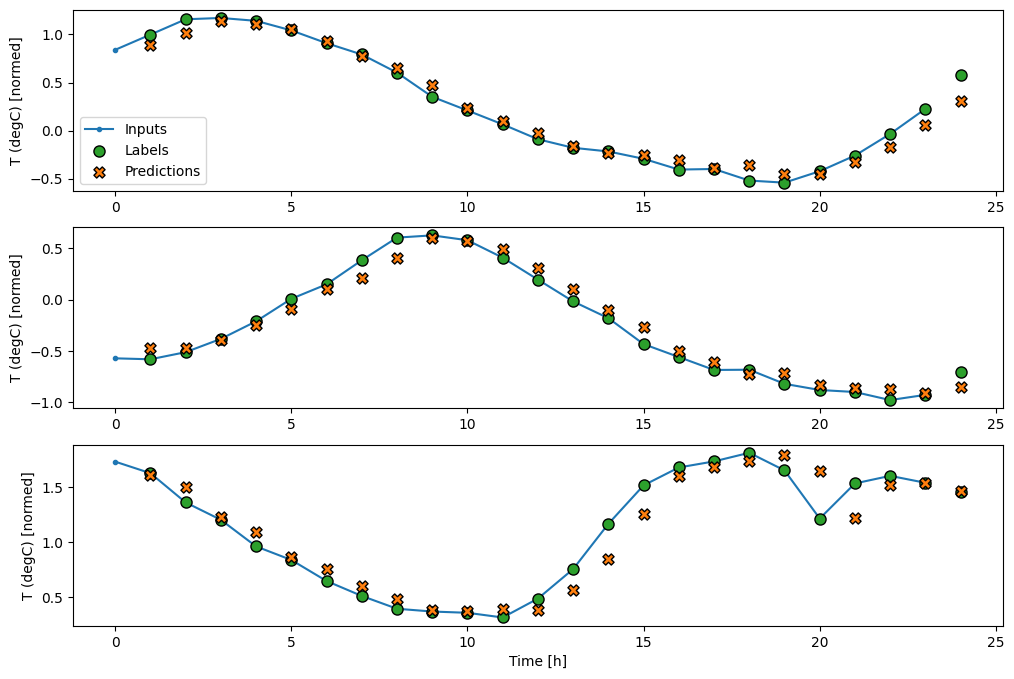

In [44]:
wide_window.plot(linear)

线性模型的优点之一是它们相对易于解释。您可以拉取层的权重，并呈现分配给每个输入的权重：

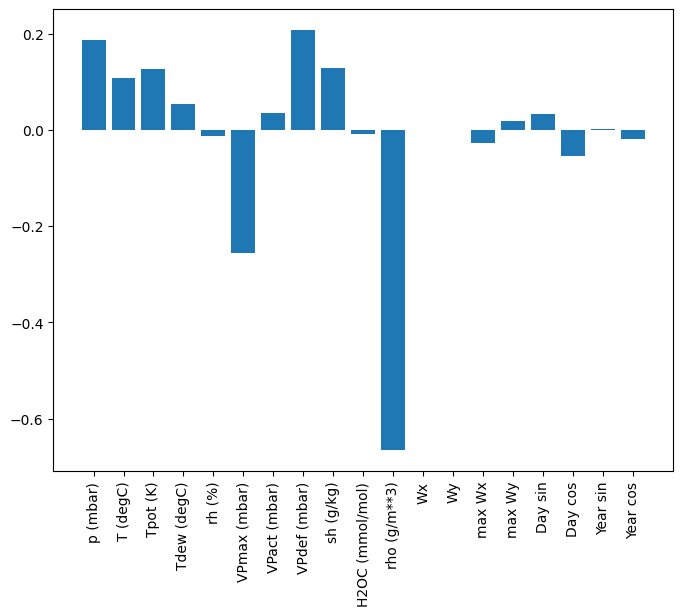

In [45]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

有时模型甚至不会将大多数权重放在输入 `T (degC)` 上。这是随机初始化的风险之一。 

### 密集

在应用实际运算多个时间步骤的模型之前，值得研究一下更深、更强大的单输入步骤模型的性能。

下面是一个与 `linear` 模型类似的模型，只不过它在输入和输出之间堆叠了几个 `Dense` 层： 

In [46]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 35:53 - loss: 1.1156 - mean_absolute_error: 0.8459

  15/1534 [..............................] - ETA: 5s - loss: 0.3251 - mean_absolute_error: 0.4141   

  30/1534 [..............................] - ETA: 5s - loss: 0.1960 - mean_absolute_error: 0.3056

  45/1534 [..............................] - ETA: 5s - loss: 0.1398 - mean_absolute_error: 0.2464

  60/1534 [>.............................] - ETA: 5s - loss: 0.1108 - mean_absolute_error: 0.2143

  75/1534 [>.............................] - ETA: 5s - loss: 0.0929 - mean_absolute_error: 0.1935

  89/1534 [>.............................] - ETA: 5s - loss: 0.0811 - mean_absolute_error: 0.1793

 104/1534 [=>............................] - ETA: 5s - loss: 0.0714 - mean_absolute_error: 0.1663

 119/1534 [=>............................] - ETA: 5s - loss: 0.0643 - mean_absolute_error: 0.1573

 134/1534 [=>............................] - ETA: 4s - loss: 0.0588 - mean_absolute_error: 0.1502

 149/1534 [=>............................] - ETA: 4s - loss: 0.0542 - mean_absolute_error: 0.1441

 163/1534 [==>...........................] - ETA: 4s - loss: 0.0508 - mean_absolute_error: 0.1397

 178/1534 [==>...........................] - ETA: 4s - loss: 0.0477 - mean_absolute_error: 0.1353

 193/1534 [==>...........................] - ETA: 4s - loss: 0.0450 - mean_absolute_error: 0.1316

 208/1534 [===>..........................] - ETA: 4s - loss: 0.0426 - mean_absolute_error: 0.1281

 223/1534 [===>..........................] - ETA: 4s - loss: 0.0405 - mean_absolute_error: 0.1249

 238/1534 [===>..........................] - ETA: 4s - loss: 0.0386 - mean_absolute_error: 0.1221

 253/1534 [===>..........................] - ETA: 4s - loss: 0.0369 - mean_absolute_error: 0.1193

 268/1534 [====>.........................] - ETA: 4s - loss: 0.0355 - mean_absolute_error: 0.1172

 283/1534 [====>.........................] - ETA: 4s - loss: 0.0341 - mean_absolute_error: 0.1149

 298/1534 [====>.........................] - ETA: 4s - loss: 0.0330 - mean_absolute_error: 0.1133

 313/1534 [=====>........................] - ETA: 4s - loss: 0.0319 - mean_absolute_error: 0.1117

 328/1534 [=====>........................] - ETA: 4s - loss: 0.0309 - mean_absolute_error: 0.1102

 343/1534 [=====>........................] - ETA: 4s - loss: 0.0300 - mean_absolute_error: 0.1085

 358/1534 [======>.......................] - ETA: 4s - loss: 0.0291 - mean_absolute_error: 0.1069

 373/1534 [======>.......................] - ETA: 4s - loss: 0.0284 - mean_absolute_error: 0.1058

 388/1534 [======>.......................] - ETA: 4s - loss: 0.0276 - mean_absolute_error: 0.1046

 403/1534 [======>.......................] - ETA: 3s - loss: 0.0270 - mean_absolute_error: 0.1036

 418/1534 [=======>......................] - ETA: 3s - loss: 0.0264 - mean_absolute_error: 0.1024

 433/1534 [=======>......................] - ETA: 3s - loss: 0.0258 - mean_absolute_error: 0.1015

 448/1534 [=======>......................] - ETA: 3s - loss: 0.0254 - mean_absolute_error: 0.1008

 463/1534 [========>.....................] - ETA: 3s - loss: 0.0249 - mean_absolute_error: 0.0999

 478/1534 [========>.....................] - ETA: 3s - loss: 0.0244 - mean_absolute_error: 0.0990

 493/1534 [========>.....................] - ETA: 3s - loss: 0.0240 - mean_absolute_error: 0.0984

 508/1534 [========>.....................] - ETA: 3s - loss: 0.0236 - mean_absolute_error: 0.0978

 523/1534 [=========>....................] - ETA: 3s - loss: 0.0232 - mean_absolute_error: 0.0972

 538/1534 [=========>....................] - ETA: 3s - loss: 0.0229 - mean_absolute_error: 0.0967

 553/1534 [=========>....................] - ETA: 3s - loss: 0.0225 - mean_absolute_error: 0.0961

 568/1534 [==========>...................] - ETA: 3s - loss: 0.0221 - mean_absolute_error: 0.0953

 583/1534 [==========>...................] - ETA: 3s - loss: 0.0218 - mean_absolute_error: 0.0947

 598/1534 [==========>...................] - ETA: 3s - loss: 0.0215 - mean_absolute_error: 0.0940

 613/1534 [==========>...................] - ETA: 3s - loss: 0.0212 - mean_absolute_error: 0.0936

 628/1534 [===========>..................] - ETA: 3s - loss: 0.0210 - mean_absolute_error: 0.0932

 643/1534 [===========>..................] - ETA: 3s - loss: 0.0208 - mean_absolute_error: 0.0927

 658/1534 [===========>..................] - ETA: 3s - loss: 0.0205 - mean_absolute_error: 0.0922

 673/1534 [============>.................] - ETA: 3s - loss: 0.0202 - mean_absolute_error: 0.0918

 688/1534 [============>.................] - ETA: 2s - loss: 0.0200 - mean_absolute_error: 0.0913

 703/1534 [============>.................] - ETA: 2s - loss: 0.0198 - mean_absolute_error: 0.0909

 718/1534 [=============>................] - ETA: 2s - loss: 0.0195 - mean_absolute_error: 0.0906

 733/1534 [=============>................] - ETA: 2s - loss: 0.0193 - mean_absolute_error: 0.0901

 748/1534 [=============>................] - ETA: 2s - loss: 0.0191 - mean_absolute_error: 0.0898

 763/1534 [=============>................] - ETA: 2s - loss: 0.0189 - mean_absolute_error: 0.0895

 777/1534 [==============>...............] - ETA: 2s - loss: 0.0187 - mean_absolute_error: 0.0892

 791/1534 [==============>...............] - ETA: 2s - loss: 0.0185 - mean_absolute_error: 0.0887

 806/1534 [==============>...............] - ETA: 2s - loss: 0.0183 - mean_absolute_error: 0.0884

 821/1534 [===============>..............] - ETA: 2s - loss: 0.0182 - mean_absolute_error: 0.0880

 836/1534 [===============>..............] - ETA: 2s - loss: 0.0180 - mean_absolute_error: 0.0878

 851/1534 [===============>..............] - ETA: 2s - loss: 0.0178 - mean_absolute_error: 0.0875

 866/1534 [===============>..............] - ETA: 2s - loss: 0.0177 - mean_absolute_error: 0.0871

 881/1534 [================>.............] - ETA: 2s - loss: 0.0175 - mean_absolute_error: 0.0867

 896/1534 [================>.............] - ETA: 2s - loss: 0.0174 - mean_absolute_error: 0.0865

 911/1534 [================>.............] - ETA: 2s - loss: 0.0172 - mean_absolute_error: 0.0861

 925/1534 [=================>............] - ETA: 2s - loss: 0.0171 - mean_absolute_error: 0.0858

 940/1534 [=================>............] - ETA: 2s - loss: 0.0169 - mean_absolute_error: 0.0855

 955/1534 [=================>............] - ETA: 2s - loss: 0.0168 - mean_absolute_error: 0.0852

 970/1534 [=================>............] - ETA: 1s - loss: 0.0167 - mean_absolute_error: 0.0850

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0166 - mean_absolute_error: 0.0848

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0165 - mean_absolute_error: 0.0846

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0164 - mean_absolute_error: 0.0844

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0163 - mean_absolute_error: 0.0843

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0162 - mean_absolute_error: 0.0841

1059/1534 [===================>..........] - ETA: 1s - loss: 0.0161 - mean_absolute_error: 0.0839

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0160 - mean_absolute_error: 0.0837

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0159 - mean_absolute_error: 0.0835

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0158 - mean_absolute_error: 0.0834

1116/1534 [====================>.........] - ETA: 1s - loss: 0.0158 - mean_absolute_error: 0.0832

1130/1534 [=====================>........] - ETA: 1s - loss: 0.0157 - mean_absolute_error: 0.0832

1144/1534 [=====================>........] - ETA: 1s - loss: 0.0157 - mean_absolute_error: 0.0830

1158/1534 [=====================>........] - ETA: 1s - loss: 0.0156 - mean_absolute_error: 0.0828

1172/1534 [=====================>........] - ETA: 1s - loss: 0.0155 - mean_absolute_error: 0.0826

1186/1534 [======================>.......] - ETA: 1s - loss: 0.0154 - mean_absolute_error: 0.0824

1201/1534 [======================>.......] - ETA: 1s - loss: 0.0153 - mean_absolute_error: 0.0822

1215/1534 [======================>.......] - ETA: 1s - loss: 0.0152 - mean_absolute_error: 0.0821

1230/1534 [=======================>......] - ETA: 1s - loss: 0.0152 - mean_absolute_error: 0.0819

1245/1534 [=======================>......] - ETA: 1s - loss: 0.0151 - mean_absolute_error: 0.0819

1259/1534 [=======================>......] - ETA: 0s - loss: 0.0150 - mean_absolute_error: 0.0817

1274/1534 [=======================>......] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.0815

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.0814

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0813

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0813

1334/1534 [=========================>....] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0812

1348/1534 [=========================>....] - ETA: 0s - loss: 0.0147 - mean_absolute_error: 0.0810

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0146 - mean_absolute_error: 0.0809

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0807

1393/1534 [==========================>...] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.0806

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0144 - mean_absolute_error: 0.0805

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0803

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0802

1453/1534 [===========================>..] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0800

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0799

1483/1534 [============================>.] - ETA: 0s - loss: 0.0141 - mean_absolute_error: 0.0798

1498/1534 [============================>.] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0797

1513/1534 [============================>.] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0796

1528/1534 [============================>.] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0795

1534/1534 [==============================] - 8s 4ms/step - loss: 0.0139 - mean_absolute_error: 0.0794 - val_loss: 0.0080 - val_mean_absolute_error: 0.0652


Epoch 2/20


   1/1534 [..............................] - ETA: 1:00 - loss: 0.0038 - mean_absolute_error: 0.0495

  15/1534 [..............................] - ETA: 5s - loss: 0.0081 - mean_absolute_error: 0.0654  

  30/1534 [..............................] - ETA: 5s - loss: 0.0095 - mean_absolute_error: 0.0692

  45/1534 [..............................] - ETA: 5s - loss: 0.0093 - mean_absolute_error: 0.0701

  59/1534 [>.............................] - ETA: 5s - loss: 0.0095 - mean_absolute_error: 0.0702

  73/1534 [>.............................] - ETA: 5s - loss: 0.0094 - mean_absolute_error: 0.0693

  88/1534 [>.............................] - ETA: 5s - loss: 0.0092 - mean_absolute_error: 0.0688

 103/1534 [=>............................] - ETA: 5s - loss: 0.0091 - mean_absolute_error: 0.0686

 118/1534 [=>............................] - ETA: 5s - loss: 0.0089 - mean_absolute_error: 0.0684

 133/1534 [=>............................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0682

 148/1534 [=>............................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0675

 163/1534 [==>...........................] - ETA: 4s - loss: 0.0086 - mean_absolute_error: 0.0675

 178/1534 [==>...........................] - ETA: 4s - loss: 0.0086 - mean_absolute_error: 0.0674

 193/1534 [==>...........................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0673

 208/1534 [===>..........................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0671

 223/1534 [===>..........................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0669

 238/1534 [===>..........................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0667

 253/1534 [===>..........................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0662

 267/1534 [====>.........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0661

 282/1534 [====>.........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0660

 297/1534 [====>.........................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0657

 312/1534 [=====>........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0656

 327/1534 [=====>........................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0654

 342/1534 [=====>........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0652

 357/1534 [=====>........................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0652

 372/1534 [======>.......................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0651

 387/1534 [======>.......................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0652

 402/1534 [======>.......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 417/1534 [=======>......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0652

 432/1534 [=======>......................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0652

 447/1534 [=======>......................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 462/1534 [========>.....................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0650

 477/1534 [========>.....................] - ETA: 3s - loss: 0.0079 - mean_absolute_error: 0.0649

 492/1534 [========>.....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0650

 507/1534 [========>.....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0650

 522/1534 [=========>....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0651

 537/1534 [=========>....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 552/1534 [=========>....................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 567/1534 [==========>...................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 582/1534 [==========>...................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0652

 597/1534 [==========>...................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0651

 612/1534 [==========>...................] - ETA: 3s - loss: 0.0080 - mean_absolute_error: 0.0651

 627/1534 [===========>..................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0652

 642/1534 [===========>..................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0653

 656/1534 [===========>..................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0655

 671/1534 [============>.................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0655

 686/1534 [============>.................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0654

 701/1534 [============>.................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0655

 716/1534 [=============>................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0655

 730/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0653

 745/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 760/1534 [=============>................] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 775/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 790/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 804/1534 [==============>...............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 819/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0651

 834/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 848/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 863/1534 [===============>..............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0652

 878/1534 [================>.............] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0652

 893/1534 [================>.............] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0651

 908/1534 [================>.............] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0651

 923/1534 [=================>............] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0650

 938/1534 [=================>............] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0650

 953/1534 [=================>............] - ETA: 2s - loss: 0.0079 - mean_absolute_error: 0.0649

 968/1534 [=================>............] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0648

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0650

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1057/1534 [===================>..........] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0649

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0650

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0650

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0651

1117/1534 [====================>.........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0651

1131/1534 [=====================>........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0651

1146/1534 [=====================>........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0651

1161/1534 [=====================>........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0650

1176/1534 [=====================>........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0650

1191/1534 [======================>.......] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0650

1206/1534 [======================>.......] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0649

1221/1534 [======================>.......] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0649

1236/1534 [=======================>......] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0649

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0650

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1281/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1326/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0649

1356/1534 [=========================>....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1371/1534 [=========================>....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0648

1491/1534 [============================>.] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1506/1534 [============================>.] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1521/1534 [============================>.] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0648

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0080 - mean_absolute_error: 0.0648 - val_loss: 0.0072 - val_mean_absolute_error: 0.0614


Epoch 3/20


   1/1534 [..............................] - ETA: 1:00 - loss: 0.0036 - mean_absolute_error: 0.0478

  15/1534 [..............................] - ETA: 5s - loss: 0.0086 - mean_absolute_error: 0.0645  

  30/1534 [..............................] - ETA: 5s - loss: 0.0087 - mean_absolute_error: 0.0642

  45/1534 [..............................] - ETA: 5s - loss: 0.0084 - mean_absolute_error: 0.0644

  60/1534 [>.............................] - ETA: 5s - loss: 0.0085 - mean_absolute_error: 0.0652

  75/1534 [>.............................] - ETA: 5s - loss: 0.0083 - mean_absolute_error: 0.0646

  89/1534 [>.............................] - ETA: 5s - loss: 0.0084 - mean_absolute_error: 0.0647

 104/1534 [=>............................] - ETA: 5s - loss: 0.0081 - mean_absolute_error: 0.0640

 118/1534 [=>............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0640

 133/1534 [=>............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0636

 147/1534 [=>............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0633

 162/1534 [==>...........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0631

 177/1534 [==>...........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0631

 192/1534 [==>...........................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0634

 207/1534 [===>..........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0633

 221/1534 [===>..........................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0634

 235/1534 [===>..........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0631

 249/1534 [===>..........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0629

 264/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0628

 278/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0626

 293/1534 [====>.........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0626

 308/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0623

 323/1534 [=====>........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0622

 338/1534 [=====>........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 353/1534 [=====>........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0619

 368/1534 [======>.......................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0618

 383/1534 [======>.......................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0618

 398/1534 [======>.......................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0619

 413/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0619

 428/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0619

 443/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0620

 458/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0619

 473/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0618

 488/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 502/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 517/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 532/1534 [=========>....................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0618

 547/1534 [=========>....................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0618

 562/1534 [=========>....................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0618

 577/1534 [==========>...................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0618

 592/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 607/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 622/1534 [===========>..................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0617

 637/1534 [===========>..................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0618

 652/1534 [===========>..................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0619

 667/1534 [============>.................] - ETA: 3s - loss: 0.0074 - mean_absolute_error: 0.0619

 682/1534 [============>.................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0618

 697/1534 [============>.................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0618

 712/1534 [============>.................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0618

 726/1534 [=============>................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0617

 740/1534 [=============>................] - ETA: 2s - loss: 0.0074 - mean_absolute_error: 0.0617

 754/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 782/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 811/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 825/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 840/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 855/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 869/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 884/1534 [================>.............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 898/1534 [================>.............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 912/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0614

 927/1534 [=================>............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0614

 942/1534 [=================>............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 957/1534 [=================>............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 972/1534 [==================>...........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0615

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0615

1002/1534 [==================>...........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0616

1017/1534 [==================>...........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0616

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0617

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0618

1062/1534 [===================>..........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0618

1077/1534 [====================>.........] - ETA: 1s - loss: 0.0073 - mean_absolute_error: 0.0618

1092/1534 [====================>.........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0619

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0619

1122/1534 [====================>.........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

1137/1534 [=====================>........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

1152/1534 [=====================>........] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

1167/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0620

1182/1534 [======================>.......] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

1197/1534 [======================>.......] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

1212/1534 [======================>.......] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0619

1227/1534 [======================>.......] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

1242/1534 [=======================>......] - ETA: 1s - loss: 0.0074 - mean_absolute_error: 0.0620

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0620

1272/1534 [=======================>......] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0620

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1302/1534 [========================>.....] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1317/1534 [========================>.....] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0620

1332/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0621

1377/1534 [=========================>....] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1392/1534 [==========================>...] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1407/1534 [==========================>...] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1437/1534 [===========================>..] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1452/1534 [===========================>..] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1497/1534 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1512/1534 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0621

1527/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0622

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0074 - mean_absolute_error: 0.0621 - val_loss: 0.0069 - val_mean_absolute_error: 0.0595


Epoch 4/20


   1/1534 [..............................] - ETA: 1:01 - loss: 0.0051 - mean_absolute_error: 0.0555

  14/1534 [..............................] - ETA: 5s - loss: 0.0068 - mean_absolute_error: 0.0600  

  28/1534 [..............................] - ETA: 5s - loss: 0.0082 - mean_absolute_error: 0.0613

  42/1534 [..............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0609

  56/1534 [>.............................] - ETA: 5s - loss: 0.0076 - mean_absolute_error: 0.0611

  70/1534 [>.............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0610

  84/1534 [>.............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0618

  98/1534 [>.............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0616

 112/1534 [=>............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0620

 127/1534 [=>............................] - ETA: 5s - loss: 0.0076 - mean_absolute_error: 0.0617

 142/1534 [=>............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0616

 157/1534 [==>...........................] - ETA: 5s - loss: 0.0073 - mean_absolute_error: 0.0612

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0615

 188/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0613

 203/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0611

 218/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0607

 233/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0608

 247/1534 [===>..........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0604

 262/1534 [====>.........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0603

 277/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0603

 292/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0602

 307/1534 [=====>........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0603

 322/1534 [=====>........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0605

 337/1534 [=====>........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0604

 352/1534 [=====>........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0601

 367/1534 [======>.......................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0599

 382/1534 [======>.......................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0600

 397/1534 [======>.......................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0601

 412/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 427/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 442/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 457/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 472/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 487/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 502/1534 [========>.....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 517/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0604

 532/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0604

 547/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0604

 562/1534 [=========>....................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0603

 577/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0603

 592/1534 [==========>...................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0603

 607/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0602

 622/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 637/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 652/1534 [===========>..................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0602

 667/1534 [============>.................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0603

 682/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0602

 697/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0603

 712/1534 [============>.................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0603

 727/1534 [=============>................] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0602

 742/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0601

 757/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0601

 772/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0601

 787/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0601

 801/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0601

 816/1534 [==============>...............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0601

 831/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0602

 846/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0603

 860/1534 [===============>..............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0602

 875/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0601

 890/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0602

 905/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0602

 920/1534 [================>.............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0602

 935/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0601

 950/1534 [=================>............] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0601

 965/1534 [=================>............] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0601

 980/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0602

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0601

1010/1534 [==================>...........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0602

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0603

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0603

1055/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0603

1070/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0604

1100/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0605

1115/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0605

1129/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0605

1143/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0606

1158/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0606

1173/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0605

1188/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0605

1203/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0605

1218/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0606

1233/1534 [=======================>......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0606

1248/1534 [=======================>......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0606

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1278/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0606

1294/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1309/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0606

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1384/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0606

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0606

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0606

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0606

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0606

1488/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0606

1503/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1518/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1533/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0607 - val_loss: 0.0069 - val_mean_absolute_error: 0.0596


Epoch 5/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0064 - mean_absolute_error: 0.0598

  15/1534 [..............................] - ETA: 5s - loss: 0.0063 - mean_absolute_error: 0.0580 

  30/1534 [..............................] - ETA: 5s - loss: 0.0082 - mean_absolute_error: 0.0606

  45/1534 [..............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0604

  59/1534 [>.............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0610

  73/1534 [>.............................] - ETA: 5s - loss: 0.0079 - mean_absolute_error: 0.0621

  88/1534 [>.............................] - ETA: 5s - loss: 0.0079 - mean_absolute_error: 0.0623

 103/1534 [=>............................] - ETA: 5s - loss: 0.0079 - mean_absolute_error: 0.0627

 118/1534 [=>............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0619

 133/1534 [=>............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0617

 147/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0613

 162/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0607

 177/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0609

 192/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0607

 206/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0607

 221/1534 [===>..........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0604

 236/1534 [===>..........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0601

 251/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0597

 266/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0596

 281/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0596

 296/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0595

 311/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0594

 326/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0593

 341/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 356/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 371/1534 [======>.......................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 386/1534 [======>.......................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 401/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 416/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 431/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0596

 446/1534 [=======>......................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0596

 461/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 476/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0595

 491/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0596

 506/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0597

 521/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0596

 536/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 551/1534 [=========>....................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 566/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0596

 581/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0597

 596/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0596

 611/1534 [==========>...................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 626/1534 [===========>..................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 641/1534 [===========>..................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0596

 656/1534 [===========>..................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0597

 671/1534 [============>.................] - ETA: 3s - loss: 0.0071 - mean_absolute_error: 0.0598

 686/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 701/1534 [============>.................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0598

 716/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0597

 731/1534 [=============>................] - ETA: 2s - loss: 0.0070 - mean_absolute_error: 0.0595

 746/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 761/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 776/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 791/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 806/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 821/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 836/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 851/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 866/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 881/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 896/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 911/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 926/1534 [=================>............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 941/1534 [=================>............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 956/1534 [=================>............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 971/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1001/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0594

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0595

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0596

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0596

1061/1534 [===================>..........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0596

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0598

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1121/1534 [====================>.........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1151/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1166/1534 [=====================>........] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1181/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1196/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1211/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1227/1534 [======================>.......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1242/1534 [=======================>......] - ETA: 1s - loss: 0.0070 - mean_absolute_error: 0.0597

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0597

1286/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1301/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1316/1534 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1331/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1361/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1421/1534 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1436/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1466/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1481/1534 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1497/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1512/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0595

1527/1534 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0596

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0070 - mean_absolute_error: 0.0596 - val_loss: 0.0068 - val_mean_absolute_error: 0.0587


Epoch 6/20


   1/1534 [..............................] - ETA: 58s - loss: 0.0055 - mean_absolute_error: 0.0543

  15/1534 [..............................] - ETA: 5s - loss: 0.0065 - mean_absolute_error: 0.0589 

  30/1534 [..............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0613

  45/1534 [..............................] - ETA: 5s - loss: 0.0070 - mean_absolute_error: 0.0603

  60/1534 [>.............................] - ETA: 5s - loss: 0.0076 - mean_absolute_error: 0.0609

  75/1534 [>.............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0611

  90/1534 [>.............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0615

 105/1534 [=>............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0611

 120/1534 [=>............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0609

 135/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0603

 150/1534 [=>............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0602

 165/1534 [==>...........................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0603

 180/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0602

 196/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0600

 211/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0596

 226/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0594

 241/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0592

 256/1534 [====>.........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0590

 271/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0589

 286/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

 301/1534 [====>.........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0589

 316/1534 [=====>........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

 331/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 346/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 361/1534 [======>.......................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 377/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 392/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0587

 407/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 422/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0590

 437/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0589

 452/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 467/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 482/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 497/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0590

 512/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 527/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 542/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 557/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 572/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0592

 587/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 602/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0592

 617/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 632/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0593

 647/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0592

 662/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 677/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 692/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0592

 707/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0594

 722/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0593

 737/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 751/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 766/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 781/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 811/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 826/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 841/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 856/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 872/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 887/1534 [================>.............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 902/1534 [================>.............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 917/1534 [================>.............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 932/1534 [=================>............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0588

 947/1534 [=================>............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0587

 962/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

 977/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1037/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1069/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1114/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1129/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0590

1144/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1159/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1174/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0591

1189/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1204/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1219/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1234/1534 [=======================>......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0590

1248/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0590

1305/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1348/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1362/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0590

1376/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1390/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1433/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1447/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1475/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1489/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1503/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1517/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1532/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0589

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0589 - val_loss: 0.0065 - val_mean_absolute_error: 0.0574


Epoch 7/20


   1/1534 [..............................] - ETA: 59s - loss: 0.0048 - mean_absolute_error: 0.0537

  14/1534 [..............................] - ETA: 5s - loss: 0.0062 - mean_absolute_error: 0.0578 

  28/1534 [..............................] - ETA: 5s - loss: 0.0084 - mean_absolute_error: 0.0623

  42/1534 [..............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0600

  56/1534 [>.............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0595

  70/1534 [>.............................] - ETA: 5s - loss: 0.0074 - mean_absolute_error: 0.0599

  85/1534 [>.............................] - ETA: 5s - loss: 0.0076 - mean_absolute_error: 0.0603

 100/1534 [>.............................] - ETA: 5s - loss: 0.0073 - mean_absolute_error: 0.0594

 114/1534 [=>............................] - ETA: 5s - loss: 0.0072 - mean_absolute_error: 0.0593

 128/1534 [=>............................] - ETA: 5s - loss: 0.0071 - mean_absolute_error: 0.0589

 142/1534 [=>............................] - ETA: 5s - loss: 0.0070 - mean_absolute_error: 0.0586

 156/1534 [==>...........................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0587

 170/1534 [==>...........................] - ETA: 5s - loss: 0.0071 - mean_absolute_error: 0.0594

 184/1534 [==>...........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0597

 198/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0595

 212/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0593

 226/1534 [===>..........................] - ETA: 4s - loss: 0.0071 - mean_absolute_error: 0.0594

 240/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0593

 254/1534 [===>..........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0590

 268/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0588

 282/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0587

 296/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0586

 310/1534 [=====>........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0586

 324/1534 [=====>........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0585

 338/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0583

 353/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0582

 368/1534 [======>.......................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0582

 382/1534 [======>.......................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0580

 396/1534 [======>.......................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0581

 410/1534 [=======>......................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0584

 424/1534 [=======>......................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0583

 438/1534 [=======>......................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0584

 452/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0583

 466/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0583

 480/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 494/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0583

 508/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 522/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 536/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 550/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 564/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0584

 578/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0585

 592/1534 [==========>...................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 606/1534 [==========>...................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0584

 620/1534 [===========>..................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0584

 634/1534 [===========>..................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0584

 648/1534 [===========>..................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0584

 662/1534 [===========>..................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0584

 676/1534 [============>.................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0584

 690/1534 [============>.................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0583

 705/1534 [============>.................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0584

 719/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0584

 733/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0582

 747/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0580

 762/1534 [=============>................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0580

 776/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 790/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 804/1534 [==============>...............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 818/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 832/1534 [===============>..............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0581

 846/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0581

 860/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0581

 874/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 888/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0581

 902/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0581

 916/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 930/1534 [=================>............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 944/1534 [=================>............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 958/1534 [=================>............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 973/1534 [==================>...........] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0580

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0580

1001/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0580

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0583

1057/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0583

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0584

1085/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0584

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1128/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1143/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1157/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1171/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1185/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0585

1199/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1213/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1227/1534 [======================>.......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1242/1534 [=======================>......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1256/1534 [=======================>......] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0586

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1298/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1342/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1356/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1371/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1400/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1488/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1503/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1518/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1533/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0586

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0586 - val_loss: 0.0067 - val_mean_absolute_error: 0.0583


Epoch 8/20


   1/1534 [..............................] - ETA: 1:01 - loss: 0.0045 - mean_absolute_error: 0.0503

  15/1534 [..............................] - ETA: 5s - loss: 0.0064 - mean_absolute_error: 0.0574  

  29/1534 [..............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0596

  43/1534 [..............................] - ETA: 5s - loss: 0.0074 - mean_absolute_error: 0.0602

  57/1534 [>.............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0613

  71/1534 [>.............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0605

  86/1534 [>.............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0608

 100/1534 [>.............................] - ETA: 5s - loss: 0.0074 - mean_absolute_error: 0.0602

 114/1534 [=>............................] - ETA: 5s - loss: 0.0072 - mean_absolute_error: 0.0596

 129/1534 [=>............................] - ETA: 5s - loss: 0.0072 - mean_absolute_error: 0.0595

 144/1534 [=>............................] - ETA: 5s - loss: 0.0070 - mean_absolute_error: 0.0589

 158/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0587

 173/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0591

 187/1534 [==>...........................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0588

 202/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0586

 216/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0583

 230/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0582

 245/1534 [===>..........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0579

 260/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 274/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 288/1534 [====>.........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0575

 302/1534 [====>.........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0576

 316/1534 [=====>........................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0576

 331/1534 [=====>........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0572

 346/1534 [=====>........................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0572

 361/1534 [======>.......................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0572

 376/1534 [======>.......................] - ETA: 4s - loss: 0.0064 - mean_absolute_error: 0.0572

 392/1534 [======>.......................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0574

 407/1534 [======>.......................] - ETA: 4s - loss: 0.0065 - mean_absolute_error: 0.0576

 422/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0576

 437/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0576

 452/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 467/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0576

 482/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0576

 497/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 512/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0579

 526/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 540/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 555/1534 [=========>....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 570/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0579

 585/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0579

 599/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0578

 614/1534 [===========>..................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0578

 629/1534 [===========>..................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 644/1534 [===========>..................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0579

 659/1534 [===========>..................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0580

 674/1534 [============>.................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0580

 689/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0579

 704/1534 [============>.................] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0579

 719/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0578

 734/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0576

 749/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 764/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 779/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 794/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 809/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 823/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 838/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 852/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 867/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 882/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 896/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 910/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 925/1534 [=================>............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 940/1534 [=================>............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 954/1534 [=================>............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 969/1534 [=================>............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0575

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0576

1012/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0577

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0577

1042/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0578

1057/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0578

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0579

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0579

1101/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0580

1115/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0580

1130/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1144/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1158/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1173/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1188/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1203/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0581

1218/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1233/1534 [=======================>......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1247/1534 [=======================>......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0582

1262/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0583

1277/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1292/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1321/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1423/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1453/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0582

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0583

1497/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0583

1512/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0583

1526/1534 [============================>.] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0583

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0067 - mean_absolute_error: 0.0583 - val_loss: 0.0068 - val_mean_absolute_error: 0.0582


  1/439 [..............................] - ETA: 37s - loss: 0.0041 - mean_absolute_error: 0.0454

 19/439 [>.............................] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0586 

 39/439 [=>............................] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0576

 59/439 [===>..........................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0577

 79/439 [====>.........................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0569

 98/439 [=====>........................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0577

118/439 [=======>......................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0576

138/439 [========>.....................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0578

158/439 [=========>....................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0579

178/439 [===========>..................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0579

198/439 [============>.................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0580

218/439 [=============>................] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0580

239/439 [===============>..............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0583

260/439 [================>.............] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0581

281/439 [==================>...........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0581

302/439 [===================>..........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0580

323/439 [=====================>........] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0582

344/439 [======================>.......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0584

364/439 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0585

384/439 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0585

404/439 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0582

424/439 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0582

439/439 [==============================] - 1s 3ms/step - loss: 0.0068 - mean_absolute_error: 0.0582


### 多步密集

单时间步骤模型没有其输入的当前值的上下文。它看不到输入特征随时间变化的情况。要解决此问题，模型在进行预测时需要访问多个时间步骤：

![每次预测都使用三个时间步骤。](images/conv_window.png)


`baseline`、`linear` 和 `dense` 模型会单独处理每个时间步骤。在这里，模型将接受多个时间步骤作为输入，以生成单个输出。

创建一个 `WindowGenerator`，它将生成 3 小时输入和 1 小时标签的批次：

请注意，`Window` 的 `shift` 参数与两个窗口的末尾相关。


In [47]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

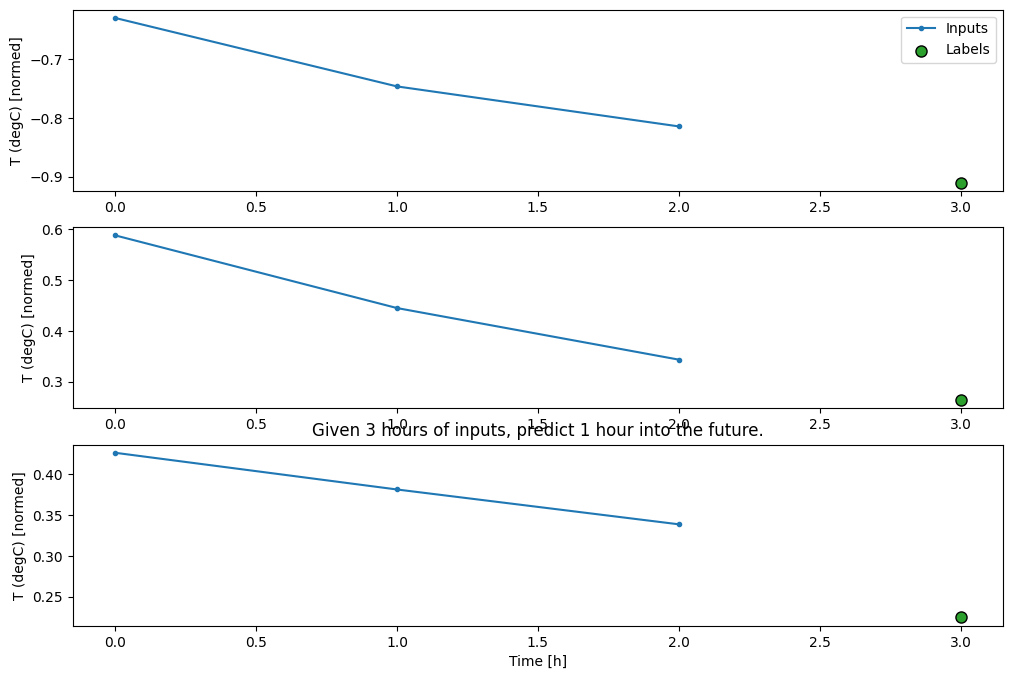

In [48]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

您可以通过添加 `tf.keras.layers.Flatten` 作为模型的第一层，在多输入步骤窗口上训练 `dense` 模型：

In [49]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [50]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 37s - loss: 0.0032 - mean_absolute_error: 0.0427

 25/438 [>.............................] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0540 

 50/438 [==>...........................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0560

 76/438 [====>.........................] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0565

102/438 [=====>........................] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0562

128/438 [=======>......................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0558

155/438 [=========>....................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0560

182/438 [===========>..................] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0560

208/438 [=============>................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0562

234/438 [===============>..............] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0560

260/438 [================>.............] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0561

286/438 [==================>...........] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0562

312/438 [====================>.........] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0562

338/438 [======================>.......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0563

364/438 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0562

390/438 [=========================>....] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0561

415/438 [===========================>..] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0557

438/438 [==============================] - 1s 2ms/step - loss: 0.0063 - mean_absolute_error: 0.0557


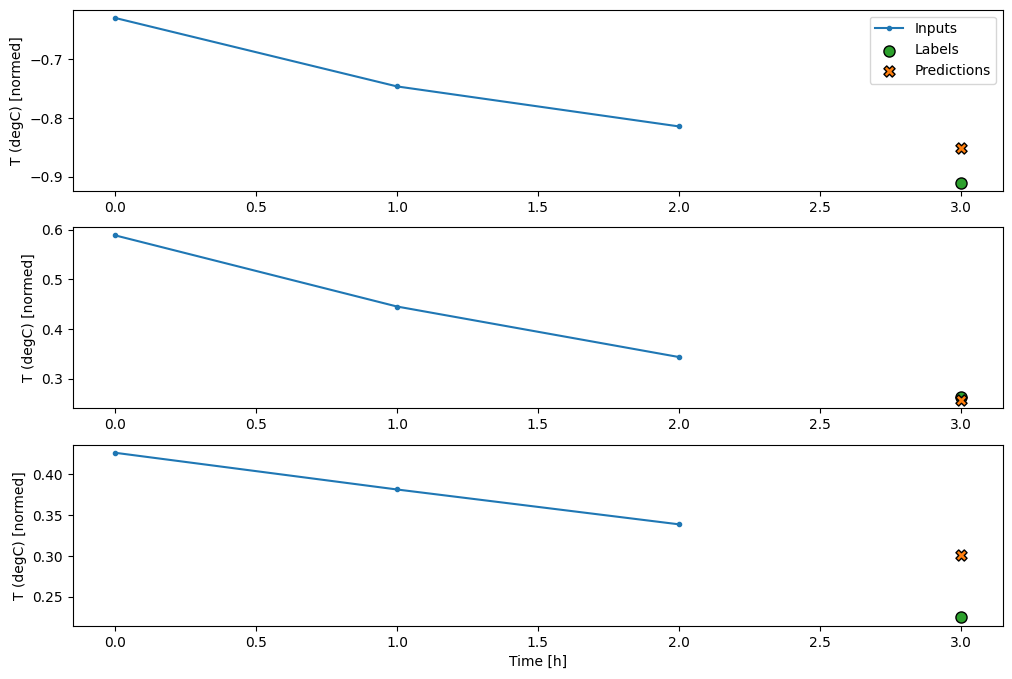

In [52]:
conv_window.plot(multi_step_dense)

此方法的主要缺点是，生成的模型只能在具有此形状的输入窗口上执行。 

In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


下一部分中的卷积模型将解决这个问题。

### 卷积神经网络

卷积层 (`tf.keras.layers.Conv1D`) 也需要多个时间步骤作为每个预测的输入。

下面的模型与 `multi_step_dense` **相同**，使用卷积进行了重写。

请注意以下变化：

- `tf.keras.layers.Flatten` 和第一个 `tf.keras.layers.Dense` 替换成了 `tf.keras.layers.Conv1D`。
- 由于卷积将时间轴保留在其输出中，不再需要 `tf.keras.layers.Reshape`。

In [54]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

在一个样本批次上运行上述模型，以查看模型是否生成了具有预期形状的输出：

In [55]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


在 `conv_window` 上训练和评估上述模型，它应该提供与 `multi_step_dense` 模型类似的性能。

In [56]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 37s - loss: 0.0044 - mean_absolute_error: 0.0577

 20/438 [>.............................] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0606 

 40/438 [=>............................] - ETA: 1s - loss: 0.0079 - mean_absolute_error: 0.0614

 61/438 [===>..........................] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0616

 82/438 [====>.........................] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0601

103/438 [======>.......................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0593

124/438 [=======>......................] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0598

145/438 [========>.....................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0594

166/438 [==========>...................] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0591

187/438 [===========>..................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0591

208/438 [=============>................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0588

229/438 [==============>...............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0590

251/438 [================>.............] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0587

272/438 [=================>............] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0587

293/438 [===================>..........] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0589

314/438 [====================>.........] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0587

334/438 [=====================>........] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0588

354/438 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0590

375/438 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0590

395/438 [==========================>...] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0590

416/438 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0591

437/438 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0592

438/438 [==============================] - 1s 2ms/step - loss: 0.0070 - mean_absolute_error: 0.0592


此 `conv_model` 和 `multi_step_dense` 模型的区别在于，`conv_model` 可以在任意长度的输入上运行。卷积层应用于输入的滑动窗口：

![在序列上执行卷积模型](images/wide_conv_window.png)

如果在较宽的输入上运行此模型，它将生成较宽的输出：

In [57]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


请注意，输出比输入短。要进行训练或绘图，需要标签和预测具有相同长度。因此，构建 `WindowGenerator` 以使用一些额外输入时间步骤生成宽窗口，从而使标签和预测长度匹配： 

In [58]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [59]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window


Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


现在，您可以在更宽的窗口上绘制模型的预测。请注意第一个预测之前的 3 个输入时间步骤。这里的每个预测都基于之前的 3 个时间步骤：

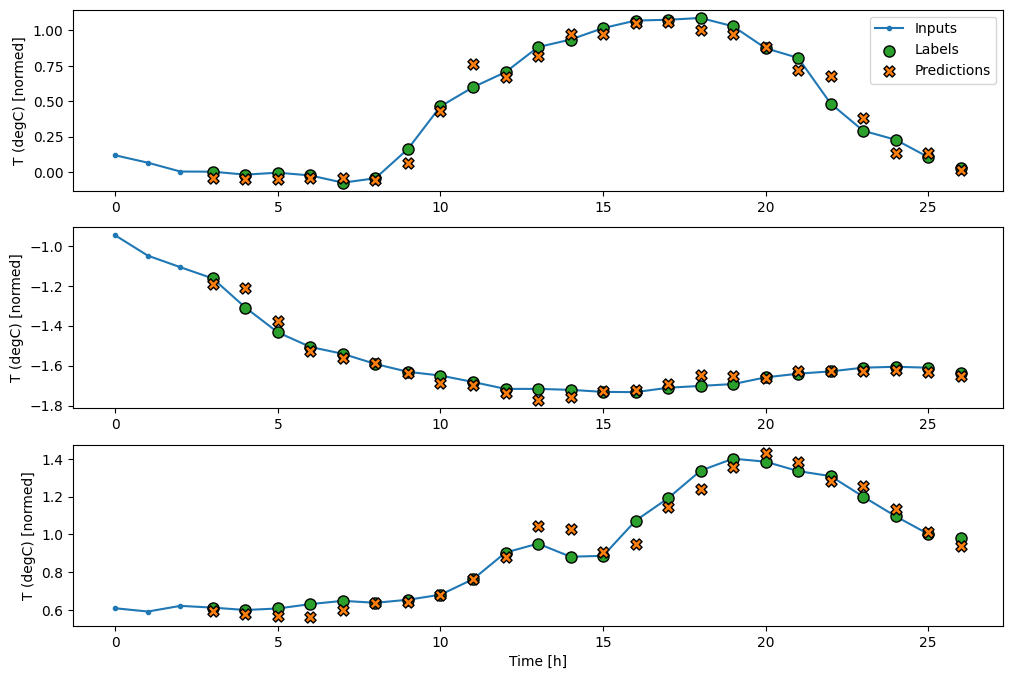

In [60]:
wide_conv_window.plot(conv_model)

### 循环神经网络

循环神经网络 (RNN) 是一种非常适合时间序列数据的神经网络。RNN 分步处理时间序列，从时间步骤到时间步骤地维护内部状态。

您可以在[使用 RNN 的文本生成](https://tensorflow.google.cn/text/tutorials/text_generation)教程和[使用 Keras 的递归神经网络 (RNN)](https://tensorflow.google.cn/guide/keras/rnn) 指南中了解详情。

在本教程中，您将使用称为“长短期记忆网络”(`tf.keras.layers.LSTM`) 的 RNN 层。

对所有 Keras RNN 层（例如 `tf.keras.layers.LSTM`）都很重要的一个构造函数参数是 `return_sequences`。此设置可以通过以下两种方式配置层：

1. 如果为 `False`（默认值），则层仅返回最终时间步骤的输出，使模型有时间在进行单个预测前对其内部状态进行预热：

![lstm 预热并进行单一预测](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/structured_data/images/lstm_1_window.png?raw=true)

1. 如果为 `True`，层将为每个输入返回一个输出。这对以下情况十分有用：
    - 堆叠 RNN 层。
    - 同时在多个时间步骤上训练模型。

![lstm在每个时间步后进行预测](images/lstm_many_window.png)

In [61]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

`return_sequences=True` 时，模型一次可以在 24 小时的数据上进行训练。

注：这将对模型的性能给出悲观看法。在第一个时间步骤中，模型无法访问之前的步骤，因此无法比之前展示的简单 `linear` 和 `dense` 模型表现得更好。

In [62]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


Output shape: (32, 24, 1)


In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 38s - loss: 0.0046 - mean_absolute_error: 0.0504

 17/438 [>.............................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0517 

 35/438 [=>............................] - ETA: 1s - loss: 0.0058 - mean_absolute_error: 0.0521

 53/438 [==>...........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0521

 71/438 [===>..........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0519

 89/438 [=====>........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0521

107/438 [======>.......................] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0522

125/438 [=======>......................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0520

143/438 [========>.....................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0520

161/438 [==========>...................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0519

179/438 [===========>..................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0519

197/438 [============>.................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0520

215/438 [=============>................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0521

234/438 [===============>..............] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0522

252/438 [================>.............] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0522

270/438 [=================>............] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0523

288/438 [==================>...........] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0522

306/438 [===================>..........] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0523

324/438 [=====================>........] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0522

342/438 [======================>.......] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0521

360/438 [=======================>......] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0522

378/438 [========================>.....] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0522

396/438 [==========================>...] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0522

414/438 [===========================>..] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0522

433/438 [============================>.] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0522

438/438 [==============================] - 1s 3ms/step - loss: 0.0057 - mean_absolute_error: 0.0522


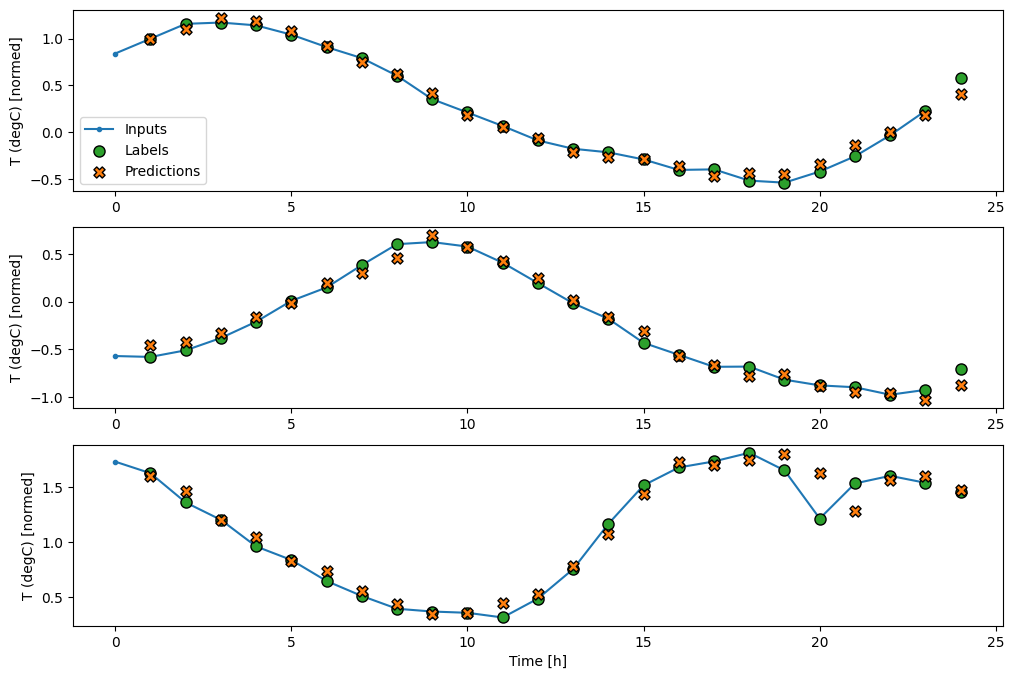

In [64]:
wide_window.plot(lstm_model)

### 性能

使用此数据集时，通常每个模型的性能都比之前的模型稍好一些：

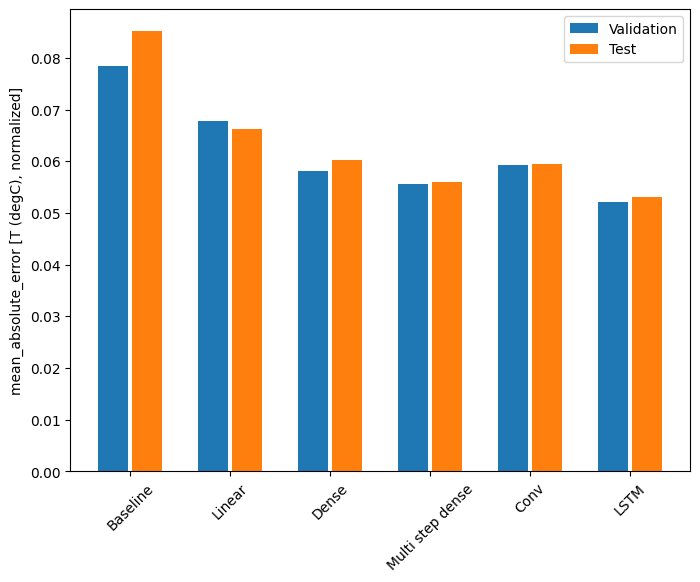

In [65]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [66]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0663
Dense       : 0.0602
Multi step dense: 0.0560
Conv        : 0.0596
LSTM        : 0.0530


### 多输出模型

到目前为止，所有模型都为单个时间步骤预测了单个输出特征，`T (degC)`。

只需更改输出层中的单元数并调整训练窗口，以将所有特征包括在 `labels` (`example_labels`) 中，就可以将所有上述模型转换为预测多个特征：

In [67]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


请注意，上面标签的 `features` 轴现在具有与输入相同的深度，而不是 1。

#### 基线

此处可以使用相同的基线模型 (`Baseline`)，但这次重复所有特征，而不是选择特定的 `label_index`：

In [68]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [69]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 1:05 - loss: 0.0914 - mean_absolute_error: 0.1671

 28/438 [>.............................] - ETA: 0s - loss: 0.0898 - mean_absolute_error: 0.1593  

 56/438 [==>...........................] - ETA: 0s - loss: 0.0898 - mean_absolute_error: 0.1596

 85/438 [====>.........................] - ETA: 0s - loss: 0.0896 - mean_absolute_error: 0.1596

114/438 [======>.......................] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1589

143/438 [========>.....................] - ETA: 0s - loss: 0.0888 - mean_absolute_error: 0.1593

172/438 [==========>...................] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1592

202/438 [============>.................] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1588

233/438 [==============>...............] - ETA: 0s - loss: 0.0885 - mean_absolute_error: 0.1589

264/438 [=================>............] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1589

293/438 [===================>..........] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1590

323/438 [=====================>........] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.1590

353/438 [=======================>......] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1589

383/438 [=========================>....] - ETA: 0s - loss: 0.0889 - mean_absolute_error: 0.1591

413/438 [===========================>..] - ETA: 0s - loss: 0.0886 - mean_absolute_error: 0.1589

438/438 [==============================] - 1s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### 密集

In [70]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [71]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 37s - loss: 0.0536 - mean_absolute_error: 0.1268

 20/439 [>.............................] - ETA: 1s - loss: 0.0629 - mean_absolute_error: 0.1275 

 40/439 [=>............................] - ETA: 1s - loss: 0.0674 - mean_absolute_error: 0.1299

 61/439 [===>..........................] - ETA: 0s - loss: 0.0689 - mean_absolute_error: 0.1313

 82/439 [====>.........................] - ETA: 0s - loss: 0.0710 - mean_absolute_error: 0.1324

102/439 [=====>........................] - ETA: 0s - loss: 0.0702 - mean_absolute_error: 0.1321

122/439 [=======>......................] - ETA: 0s - loss: 0.0697 - mean_absolute_error: 0.1321

143/439 [========>.....................] - ETA: 0s - loss: 0.0695 - mean_absolute_error: 0.1326

164/439 [==========>...................] - ETA: 0s - loss: 0.0695 - mean_absolute_error: 0.1327

185/439 [===========>..................] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.1321

206/439 [=============>................] - ETA: 0s - loss: 0.0698 - mean_absolute_error: 0.1325

227/439 [==============>...............] - ETA: 0s - loss: 0.0692 - mean_absolute_error: 0.1321

249/439 [================>.............] - ETA: 0s - loss: 0.0684 - mean_absolute_error: 0.1315

270/439 [=================>............] - ETA: 0s - loss: 0.0685 - mean_absolute_error: 0.1314

290/439 [==================>...........] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.1314

309/439 [====================>.........] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1312

329/439 [=====================>........] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1311

350/439 [======================>.......] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1309

371/439 [========================>.....] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1309

391/439 [=========================>....] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1309

412/439 [===========================>..] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1310

432/439 [============================>.] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1309

439/439 [==============================] - 1s 3ms/step - loss: 0.0679 - mean_absolute_error: 0.1310


#### RNN


In [72]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 38s - loss: 0.0575 - mean_absolute_error: 0.1175

 18/438 [>.............................] - ETA: 1s - loss: 0.0617 - mean_absolute_error: 0.1190 

 35/438 [=>............................] - ETA: 1s - loss: 0.0610 - mean_absolute_error: 0.1191

 53/438 [==>...........................] - ETA: 1s - loss: 0.0618 - mean_absolute_error: 0.1198

 71/438 [===>..........................] - ETA: 1s - loss: 0.0616 - mean_absolute_error: 0.1198

 89/438 [=====>........................] - ETA: 1s - loss: 0.0612 - mean_absolute_error: 0.1194

107/438 [======>.......................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1199

125/438 [=======>......................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1201

143/438 [========>.....................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1201

161/438 [==========>...................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1200

179/438 [===========>..................] - ETA: 0s - loss: 0.0618 - mean_absolute_error: 0.1198

197/438 [============>.................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1197

215/438 [=============>................] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1196

233/438 [==============>...............] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.1197

251/438 [================>.............] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1195

269/438 [=================>............] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1195

287/438 [==================>...........] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1194

305/438 [===================>..........] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1195

323/438 [=====================>........] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1195

341/438 [======================>.......] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1196

359/438 [=======================>......] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1195

377/438 [========================>.....] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1194

395/438 [==========================>...] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1194

413/438 [===========================>..] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1194

431/438 [============================>.] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1195

438/438 [==============================] - 1s 3ms/step - loss: 0.0613 - mean_absolute_error: 0.1195



CPU times: user 5min 54s, sys: 1min 12s, total: 7min 7s
Wall time: 2min 38s


<a id="residual"></a>

#### 高级：残差连接

先前的 `Baseline` 模型利用了以下事实：序列在时间步骤之间不会剧烈变化。到目前为止，本教程中训练的每个模型都进行了随机初始化，然后必须学习输出相较上一个时间步骤改变较小这一知识。

尽管您可以通过仔细初始化来解决此问题，但将此问题构建到模型结构中则更加简单。

在时间序列分析中构建的模型，通常会预测下一个时间步骤中的值会如何变化，而非直接预测下一个值。类似地，深度学习中的<a href="https://arxiv.org/abs/1512.03385" class="external">残差网络</a>（或 ResNet）指的是，每一层都会添加到模型的累计结果中的架构。

这就是利用“改变应该较小”这一知识的方式。

![带有残差连接的模型](images/residual.png)

本质上，这将初始化模型以匹配 `Baseline`。对于此任务，它可以帮助模型更快收敛，且性能稍好。

该方法可以与本教程中讨论的任何模型结合使用。

这里将它应用于 LSTM 模型，请注意 `tf.initializers.zeros` 的使用，以确保初始的预测改变很小，并且不会压制残差连接。此处的梯度没有破坏对称性的问题，因为 `zeros` 仅用于最后一层。

In [73]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [74]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 37s - loss: 0.0725 - mean_absolute_error: 0.1277

 18/438 [>.............................] - ETA: 1s - loss: 0.0617 - mean_absolute_error: 0.1171 

 35/438 [=>............................] - ETA: 1s - loss: 0.0624 - mean_absolute_error: 0.1183

 52/438 [==>...........................] - ETA: 1s - loss: 0.0611 - mean_absolute_error: 0.1172

 69/438 [===>..........................] - ETA: 1s - loss: 0.0623 - mean_absolute_error: 0.1181

 86/438 [====>.........................] - ETA: 1s - loss: 0.0621 - mean_absolute_error: 0.1180

103/438 [======>.......................] - ETA: 1s - loss: 0.0621 - mean_absolute_error: 0.1180

121/438 [=======>......................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1180

138/438 [========>.....................] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1182

155/438 [=========>....................] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.1182

173/438 [==========>...................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1181

190/438 [============>.................] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1180

207/438 [=============>................] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1181

224/438 [==============>...............] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1181

241/438 [===============>..............] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1181

258/438 [================>.............] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1181

275/438 [=================>............] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1181

293/438 [===================>..........] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1179

310/438 [====================>.........] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1180

327/438 [=====================>........] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1180

345/438 [======================>.......] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1180

362/438 [=======================>......] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1181

379/438 [========================>.....] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1179

396/438 [==========================>...] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.1180

414/438 [===========================>..] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1180

432/438 [============================>.] - ETA: 0s - loss: 0.0622 - mean_absolute_error: 0.1180

438/438 [==============================] - 1s 3ms/step - loss: 0.0622 - mean_absolute_error: 0.1180



CPU times: user 1min 59s, sys: 23.3 s, total: 2min 23s
Wall time: 54.9 s


#### 性能

以下是这些多输出模型的整体性能。

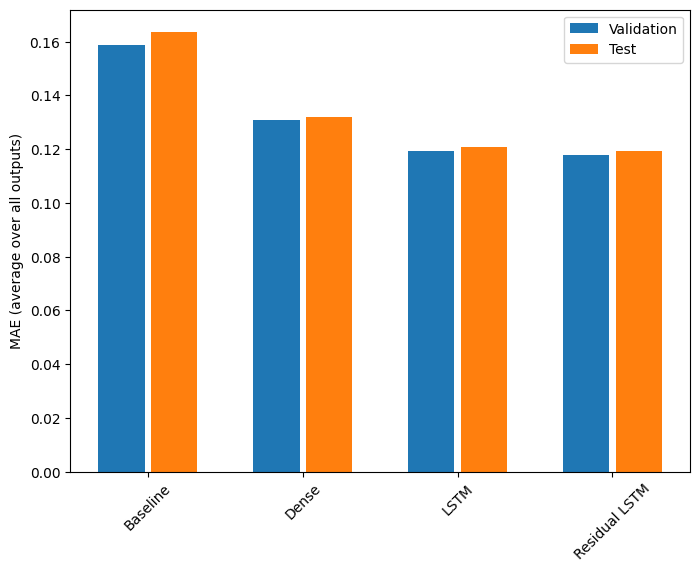

In [75]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [76]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1320
LSTM           : 0.1209
Residual LSTM  : 0.1193


以上性能是所有模型输出的平均值。

## 多步模型

前几个部分中的单输出和多输出模型都对未来 1 小时进行**单个时间步骤预测**。

本部分介绍如何扩展这些模型以进行**多时间步骤预测**。

在多步预测中，模型需要学习预测一系列未来值。因此，与单步模型（仅预测单个未来点）不同，多步模型预测未来值的序列。

大致有两种预测方法：

1. 单次预测，一次预测整个时间序列。
2. 自回归预测，模型仅进行单步预测并将输出作为输入进行反馈。

在本部分中，所有模型都将预测**所有输出时间步骤中的所有特征**。


对于多步模型而言，训练数据仍由每小时样本组成。但是，在这里，模型将在给定过去 24 小时的情况下学习预测未来 24 小时。

下面是一个 `Window` 对象，该对象从数据集生成以下切片：

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

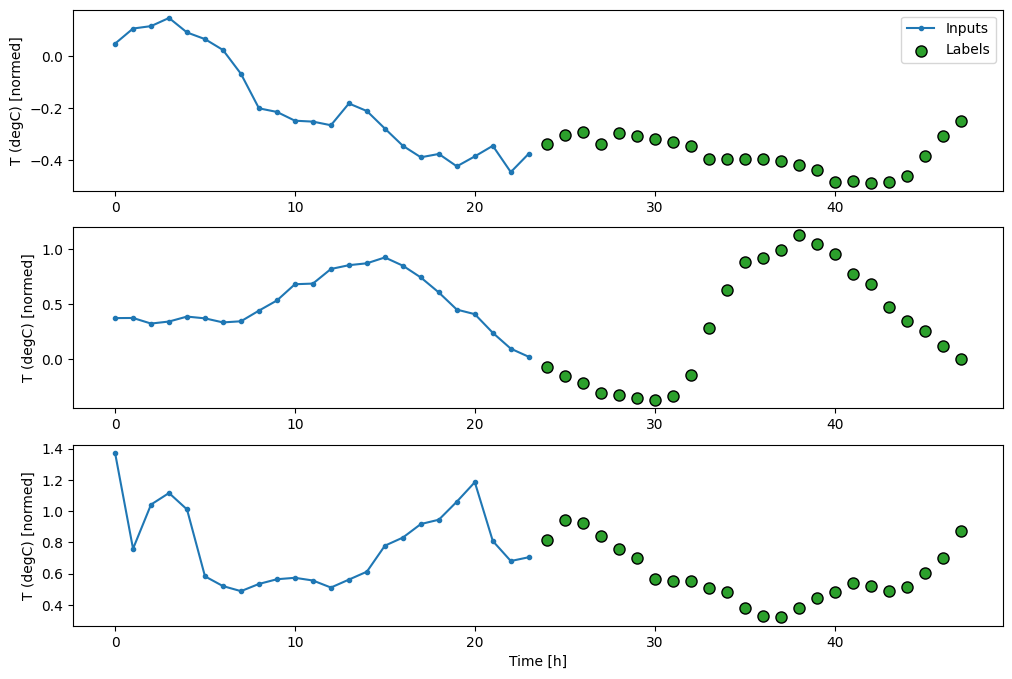

In [77]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### 基线

此任务的一个简单基线是针对所需数量的输出时间步骤重复上一个输入时间步骤：

![对每个输出步骤重复最后一次输入](images/multistep_last.png)

  1/437 [..............................] - ETA: 1:19 - loss: 0.6598 - mean_absolute_error: 0.5127

 27/437 [>.............................] - ETA: 0s - loss: 0.6180 - mean_absolute_error: 0.4972  

 54/437 [==>...........................] - ETA: 0s - loss: 0.6205 - mean_absolute_error: 0.4990

 81/437 [====>.........................] - ETA: 0s - loss: 0.6177 - mean_absolute_error: 0.4967

109/437 [======>.......................] - ETA: 0s - loss: 0.6215 - mean_absolute_error: 0.4982

136/437 [========>.....................] - ETA: 0s - loss: 0.6182 - mean_absolute_error: 0.4966

164/437 [==========>...................] - ETA: 0s - loss: 0.6224 - mean_absolute_error: 0.4978

192/437 [============>.................] - ETA: 0s - loss: 0.6243 - mean_absolute_error: 0.4987

219/437 [==============>...............] - ETA: 0s - loss: 0.6256 - mean_absolute_error: 0.4995

246/437 [===============>..............] - ETA: 0s - loss: 0.6255 - mean_absolute_error: 0.4994

273/437 [=================>............] - ETA: 0s - loss: 0.6272 - mean_absolute_error: 0.4999

300/437 [===================>..........] - ETA: 0s - loss: 0.6270 - mean_absolute_error: 0.4998

329/437 [=====================>........] - ETA: 0s - loss: 0.6301 - mean_absolute_error: 0.5012

358/437 [=======================>......] - ETA: 0s - loss: 0.6281 - mean_absolute_error: 0.5001

384/437 [=========================>....] - ETA: 0s - loss: 0.6282 - mean_absolute_error: 0.5003

411/437 [===========================>..] - ETA: 0s - loss: 0.6285 - mean_absolute_error: 0.5006

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


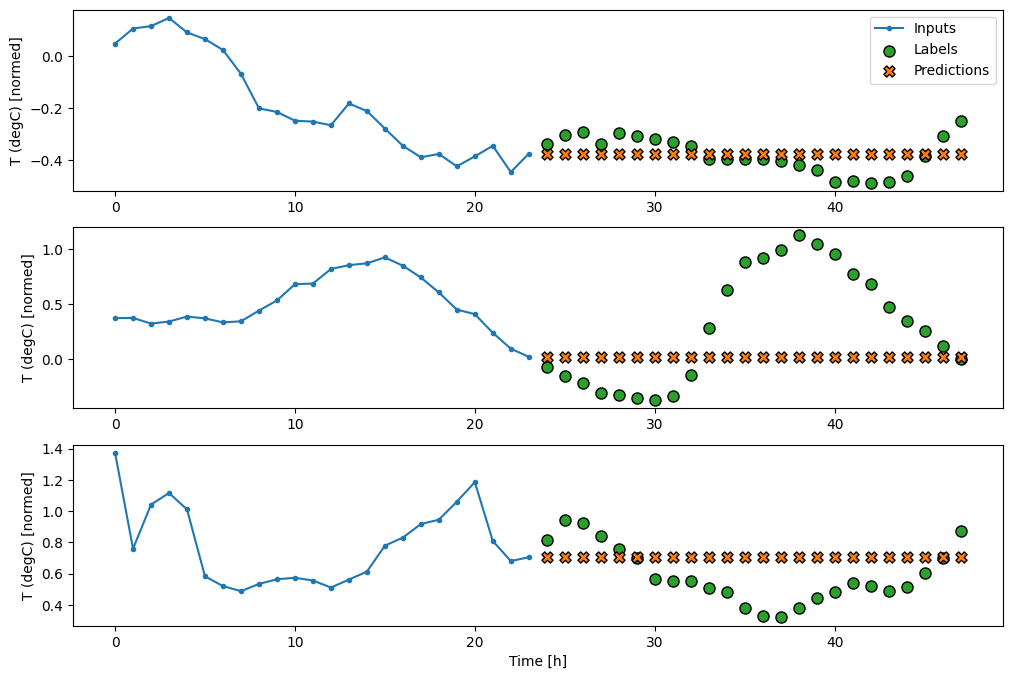

In [78]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

由于此任务是在给定过去 24 小时的情况下预测未来 24 小时，另一种简单的方式是重复前一天，假设明天是类似的：

![重复前一天](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 1:11 - loss: 0.4457 - mean_absolute_error: 0.3843

 29/437 [>.............................] - ETA: 0s - loss: 0.4286 - mean_absolute_error: 0.3911  

 57/437 [==>...........................] - ETA: 0s - loss: 0.4227 - mean_absolute_error: 0.3915

 86/437 [====>.........................] - ETA: 0s - loss: 0.4231 - mean_absolute_error: 0.3924

115/437 [======>.......................] - ETA: 0s - loss: 0.4233 - mean_absolute_error: 0.3932

144/437 [========>.....................] - ETA: 0s - loss: 0.4262 - mean_absolute_error: 0.3946

173/437 [==========>...................] - ETA: 0s - loss: 0.4263 - mean_absolute_error: 0.3947

202/437 [============>.................] - ETA: 0s - loss: 0.4268 - mean_absolute_error: 0.3953

231/437 [==============>...............] - ETA: 0s - loss: 0.4279 - mean_absolute_error: 0.3960

260/437 [================>.............] - ETA: 0s - loss: 0.4271 - mean_absolute_error: 0.3958

288/437 [==================>...........] - ETA: 0s - loss: 0.4271 - mean_absolute_error: 0.3960

317/437 [====================>.........] - ETA: 0s - loss: 0.4272 - mean_absolute_error: 0.3959

345/437 [======================>.......] - ETA: 0s - loss: 0.4273 - mean_absolute_error: 0.3957

374/437 [========================>.....] - ETA: 0s - loss: 0.4277 - mean_absolute_error: 0.3961

404/437 [==========================>...] - ETA: 0s - loss: 0.4269 - mean_absolute_error: 0.3958

435/437 [============================>.] - ETA: 0s - loss: 0.4269 - mean_absolute_error: 0.3958

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


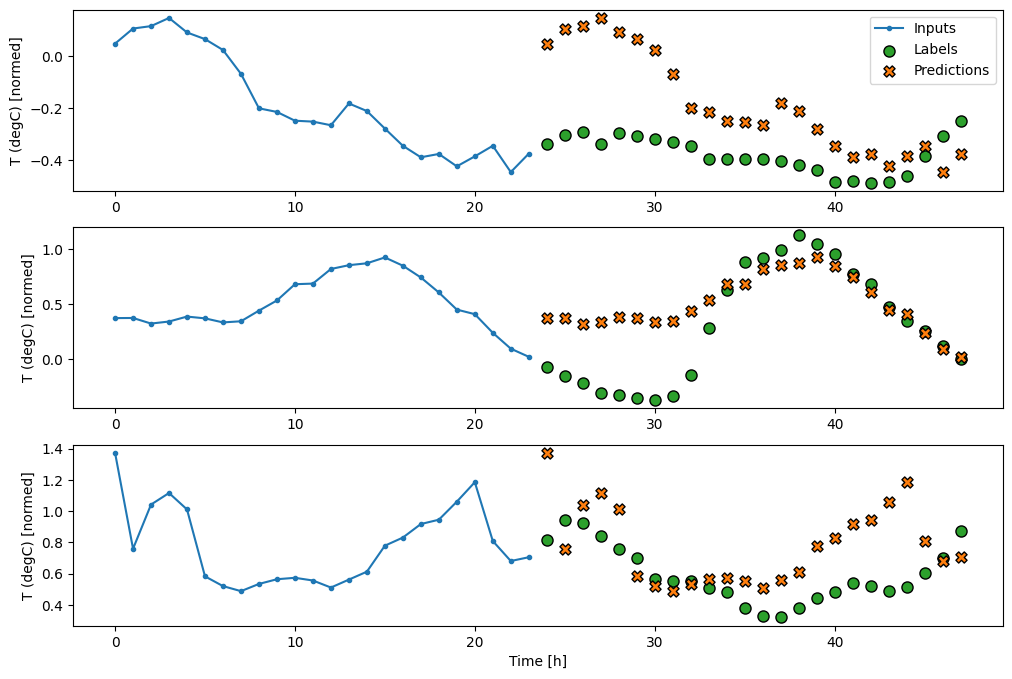

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### 单次模型

解决此问题的一种高级方法是使用“单次”模型，该模型可以在单个步骤中对整个序列进行预测。

这可以使用 `OUT_STEPS*features` 输出单元作为 `tf.keras.layers.Dense` 高效实现。模型只需要将输出调整为所需的 `(OUTPUT_STEPS, features)`。

#### 线性

基于最后输入时间步骤的简单线性模型优于任何基线，但能力不足。该模型需要根据线性投影的单个输入时间步骤来预测 `OUTPUT_STEPS` 个时间步骤。它只能捕获行为的低维度切片，可能主要基于一天中的时间和一年中的时间。

![从上一个时间步骤预测所有时间步骤](images/multistep_dense.png)

  1/437 [..............................] - ETA: 34s - loss: 0.2738 - mean_absolute_error: 0.3158

 25/437 [>.............................] - ETA: 0s - loss: 0.2477 - mean_absolute_error: 0.3021 

 49/437 [==>...........................] - ETA: 0s - loss: 0.2502 - mean_absolute_error: 0.3031

 73/437 [====>.........................] - ETA: 0s - loss: 0.2527 - mean_absolute_error: 0.3033

 97/437 [=====>........................] - ETA: 0s - loss: 0.2530 - mean_absolute_error: 0.3036

122/437 [=======>......................] - ETA: 0s - loss: 0.2537 - mean_absolute_error: 0.3038

147/437 [=========>....................] - ETA: 0s - loss: 0.2551 - mean_absolute_error: 0.3049

171/437 [==========>...................] - ETA: 0s - loss: 0.2537 - mean_absolute_error: 0.3042

196/437 [============>.................] - ETA: 0s - loss: 0.2553 - mean_absolute_error: 0.3051

220/437 [==============>...............] - ETA: 0s - loss: 0.2552 - mean_absolute_error: 0.3050

243/437 [===============>..............] - ETA: 0s - loss: 0.2554 - mean_absolute_error: 0.3052

266/437 [=================>............] - ETA: 0s - loss: 0.2564 - mean_absolute_error: 0.3054

290/437 [==================>...........] - ETA: 0s - loss: 0.2564 - mean_absolute_error: 0.3052

315/437 [====================>.........] - ETA: 0s - loss: 0.2553 - mean_absolute_error: 0.3047

339/437 [======================>.......] - ETA: 0s - loss: 0.2549 - mean_absolute_error: 0.3046

363/437 [=======================>......] - ETA: 0s - loss: 0.2553 - mean_absolute_error: 0.3049

386/437 [=========================>....] - ETA: 0s - loss: 0.2548 - mean_absolute_error: 0.3045

410/437 [===========================>..] - ETA: 0s - loss: 0.2546 - mean_absolute_error: 0.3045

435/437 [============================>.] - ETA: 0s - loss: 0.2554 - mean_absolute_error: 0.3049

437/437 [==============================] - 1s 2ms/step - loss: 0.2552 - mean_absolute_error: 0.3049


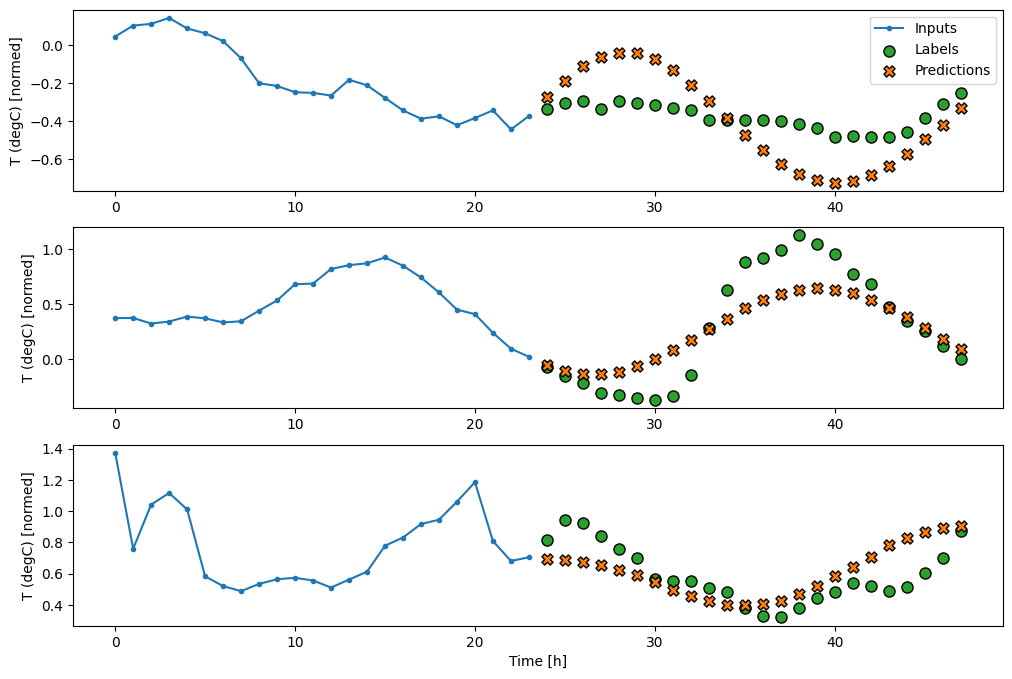

In [80]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### 密集

在输入和输出之间添加 `tf.keras.layers.Dense` 可为线性模型提供更大能力，但仍仅基于单个输入时间步骤。

  1/437 [..............................] - ETA: 36s - loss: 0.2202 - mean_absolute_error: 0.2900

 21/437 [>.............................] - ETA: 1s - loss: 0.2141 - mean_absolute_error: 0.2792 

 42/437 [=>............................] - ETA: 1s - loss: 0.2166 - mean_absolute_error: 0.2808

 63/437 [===>..........................] - ETA: 0s - loss: 0.2163 - mean_absolute_error: 0.2804

 83/437 [====>.........................] - ETA: 0s - loss: 0.2185 - mean_absolute_error: 0.2816

103/437 [======>.......................] - ETA: 0s - loss: 0.2192 - mean_absolute_error: 0.2818

125/437 [=======>......................] - ETA: 0s - loss: 0.2190 - mean_absolute_error: 0.2815

146/437 [=========>....................] - ETA: 0s - loss: 0.2183 - mean_absolute_error: 0.2812

168/437 [==========>...................] - ETA: 0s - loss: 0.2190 - mean_absolute_error: 0.2812

189/437 [===========>..................] - ETA: 0s - loss: 0.2196 - mean_absolute_error: 0.2817

210/437 [=============>................] - ETA: 0s - loss: 0.2202 - mean_absolute_error: 0.2822

231/437 [==============>...............] - ETA: 0s - loss: 0.2203 - mean_absolute_error: 0.2822

253/437 [================>.............] - ETA: 0s - loss: 0.2202 - mean_absolute_error: 0.2820

275/437 [=================>............] - ETA: 0s - loss: 0.2203 - mean_absolute_error: 0.2823

297/437 [===================>..........] - ETA: 0s - loss: 0.2200 - mean_absolute_error: 0.2822

318/437 [====================>.........] - ETA: 0s - loss: 0.2196 - mean_absolute_error: 0.2820

339/437 [======================>.......] - ETA: 0s - loss: 0.2195 - mean_absolute_error: 0.2819

361/437 [=======================>......] - ETA: 0s - loss: 0.2199 - mean_absolute_error: 0.2823

382/437 [=========================>....] - ETA: 0s - loss: 0.2197 - mean_absolute_error: 0.2820

404/437 [==========================>...] - ETA: 0s - loss: 0.2193 - mean_absolute_error: 0.2817

425/437 [============================>.] - ETA: 0s - loss: 0.2197 - mean_absolute_error: 0.2819

437/437 [==============================] - 1s 2ms/step - loss: 0.2198 - mean_absolute_error: 0.2821


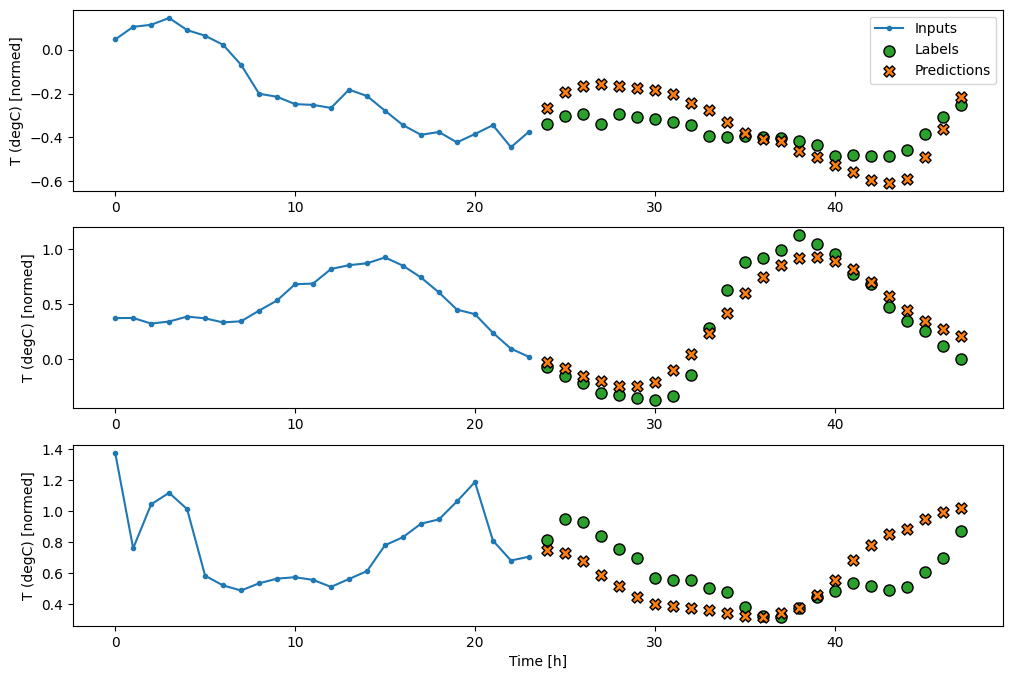

In [81]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

卷积模型基于固定宽度的历史记录进行预测，可能比密集模型的性能更好，因为它可以看到随时间变化的情况：

![卷积模型查看事物如何随时间变化。](images/multistep_conv.png)

  1/437 [..............................] - ETA: 36s - loss: 0.2199 - mean_absolute_error: 0.2917

 22/437 [>.............................] - ETA: 1s - loss: 0.2105 - mean_absolute_error: 0.2779 

 44/437 [==>...........................] - ETA: 0s - loss: 0.2171 - mean_absolute_error: 0.2809

 66/437 [===>..........................] - ETA: 0s - loss: 0.2168 - mean_absolute_error: 0.2813

 88/437 [=====>........................] - ETA: 0s - loss: 0.2151 - mean_absolute_error: 0.2807

110/437 [======>.......................] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2811

132/437 [========>.....................] - ETA: 0s - loss: 0.2153 - mean_absolute_error: 0.2804

154/437 [=========>....................] - ETA: 0s - loss: 0.2158 - mean_absolute_error: 0.2810

175/437 [===========>..................] - ETA: 0s - loss: 0.2165 - mean_absolute_error: 0.2813

196/437 [============>.................] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2810

218/437 [=============>................] - ETA: 0s - loss: 0.2155 - mean_absolute_error: 0.2810

240/437 [===============>..............] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2806

262/437 [================>.............] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2807

284/437 [==================>...........] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2807

306/437 [====================>.........] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2807

327/437 [=====================>........] - ETA: 0s - loss: 0.2142 - mean_absolute_error: 0.2805

348/437 [======================>.......] - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.2804

369/437 [========================>.....] - ETA: 0s - loss: 0.2136 - mean_absolute_error: 0.2804

390/437 [=========================>....] - ETA: 0s - loss: 0.2137 - mean_absolute_error: 0.2804

411/437 [===========================>..] - ETA: 0s - loss: 0.2135 - mean_absolute_error: 0.2803

433/437 [============================>.] - ETA: 0s - loss: 0.2132 - mean_absolute_error: 0.2801

437/437 [==============================] - 1s 2ms/step - loss: 0.2132 - mean_absolute_error: 0.2801


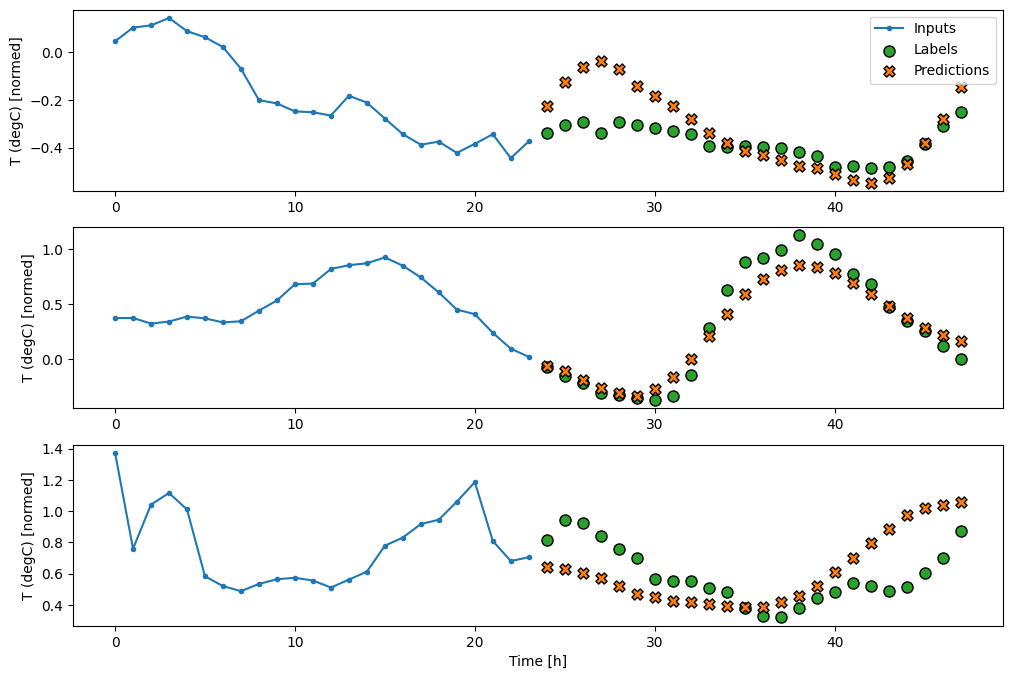

In [82]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

如果循环模型与模型所做的预测相关，则可以学习使用较长的输入历史记录。在这里，模型将积累 24 小时的内部状态，然后对接下来的 24 小时进行单次预测。

在此单次格式中，LSTM 只需要在最后一个时间步骤上生成输出，因此在 `tf.keras.layers.LSTM` 中设置 `return_sequences=False`。

![lstm 积累输入窗口的状态，并对未来 24 小时进行一次预测。](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 37s - loss: 0.1948 - mean_absolute_error: 0.2860

 19/437 [>.............................] - ETA: 1s - loss: 0.2198 - mean_absolute_error: 0.2879 

 39/437 [=>............................] - ETA: 1s - loss: 0.2167 - mean_absolute_error: 0.2853

 59/437 [===>..........................] - ETA: 0s - loss: 0.2187 - mean_absolute_error: 0.2864

 79/437 [====>.........................] - ETA: 0s - loss: 0.2171 - mean_absolute_error: 0.2861

 99/437 [=====>........................] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2862

119/437 [=======>......................] - ETA: 0s - loss: 0.2186 - mean_absolute_error: 0.2871

140/437 [========>.....................] - ETA: 0s - loss: 0.2169 - mean_absolute_error: 0.2863

160/437 [=========>....................] - ETA: 0s - loss: 0.2163 - mean_absolute_error: 0.2859

180/437 [===========>..................] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2854

200/437 [============>.................] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2848

220/437 [==============>...............] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2853

240/437 [===============>..............] - ETA: 0s - loss: 0.2150 - mean_absolute_error: 0.2852

261/437 [================>.............] - ETA: 0s - loss: 0.2151 - mean_absolute_error: 0.2852

281/437 [==================>...........] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.2852

301/437 [===================>..........] - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.2855

321/437 [=====================>........] - ETA: 0s - loss: 0.2158 - mean_absolute_error: 0.2856

341/437 [======================>.......] - ETA: 0s - loss: 0.2153 - mean_absolute_error: 0.2853

361/437 [=======================>......] - ETA: 0s - loss: 0.2150 - mean_absolute_error: 0.2855

381/437 [=========================>....] - ETA: 0s - loss: 0.2149 - mean_absolute_error: 0.2853

401/437 [==========================>...] - ETA: 0s - loss: 0.2147 - mean_absolute_error: 0.2853

421/437 [===========================>..] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2852

437/437 [==============================] - 1s 3ms/step - loss: 0.2148 - mean_absolute_error: 0.2852


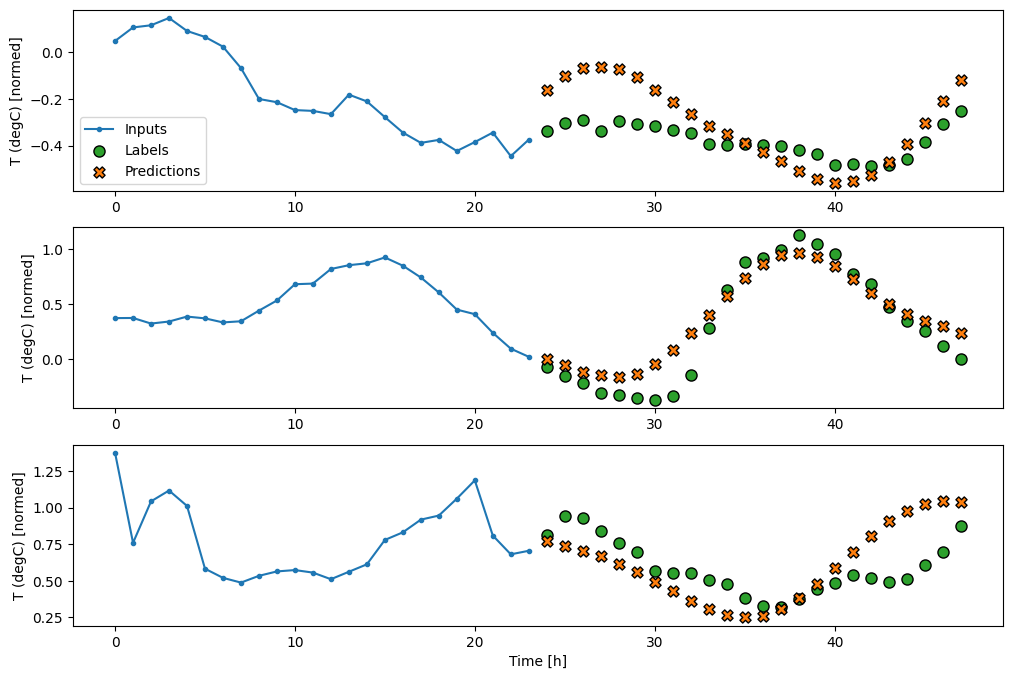

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### 高级：自回归模型

上述模型均在单个步骤中预测整个输出序列。

在某些情况下，模型将此预测分解为单个时间步骤可能比较有帮助。 然后，模型的每个输出都可以在每个步骤反馈给自己，并可以根据前一个输出进行预测，就像经典的<a href="https://arxiv.org/abs/1308.0850" class="external">使用循环神经网络生成序列</a>中介绍的一样。

此类模型的一个明显优势是可以将其设置为生成长度不同的输出。

您可以采用本教程前半部分中训练的任意一个单步多输出模型，并在自回归反馈循环中运行，但是在这里，您将重点关注经过显式训练的模型。

![将模型的输出反馈到其输入](images/multistep_autoregressive.png)

#### RNN

本教程仅构建自回归 RNN 模型，但是该模式可以应用于设计为输出单个时间步骤的任何模型。

模型将具有与之前的单步 LSTM 模型相同的基本形式：一个 `tf.keras.layers.LSTM` ，后接一个将 `LSTM` 层输出转换为模型预测的 `tf.keras.layers.Dense` 层。

`tf.keras.layers.LSTM` 是封装在更高级 `tf.keras.layers.RNN` 中的 `tf.keras.layers.LSTMCell`，它为您管理状态和序列结果（有关详细信息，请参阅[使用 Keras 的循环神经网络 (RNN)](https://tensorflow.google.cn/guide/keras/rnn) 指南）。

在这种情况下，模型必须手动管理每个步骤的输入，因此它直接将 `tf.keras.layers.LSTMCell` 用于较低级别的单个时间步骤接口。

In [84]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [85]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

该模型需要的第一个方法是 `warmup`，用来根据输入初始化其内部状态。训练后，此状态将捕获输入历史记录的相关部分。这等效于先前的单步 `LSTM` 模型：

In [86]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

此方法返回单个时间步骤预测以及 `LSTM` 的内部状态：

In [87]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

有了 `RNN` 的状态和初始预测，您现在可以继续迭代模型，并在每一步将预测作为输入反馈给模型。

收集输出预测的最简单方式是使用 Python 列表，并在循环后使用 `tf.stack`。

注：像这样堆叠 Python 列表仅适用于 Eager-Execution，使用 `Model.compile(..., run_eagerly=True)` 进行训练，或使用固定长度的输出。对于动态输出长度，您需要使用 `tf.TensorArray` 代替 Python 列表，并用 `tf.range` 代替 Python `range`。

In [88]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

在示例输入上运行此模型：

In [89]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


现在，训练模型：

  1/437 [..............................] - ETA: 41s - loss: 0.1713 - mean_absolute_error: 0.2688

  7/437 [..............................] - ETA: 4s - loss: 0.2211 - mean_absolute_error: 0.2969 

 13/437 [..............................] - ETA: 3s - loss: 0.2239 - mean_absolute_error: 0.2998

 19/437 [>.............................] - ETA: 3s - loss: 0.2340 - mean_absolute_error: 0.3050

 25/437 [>.............................] - ETA: 3s - loss: 0.2327 - mean_absolute_error: 0.3054

 31/437 [=>............................] - ETA: 3s - loss: 0.2303 - mean_absolute_error: 0.3048

 37/437 [=>............................] - ETA: 3s - loss: 0.2294 - mean_absolute_error: 0.3045

 43/437 [=>............................] - ETA: 3s - loss: 0.2276 - mean_absolute_error: 0.3035

 49/437 [==>...........................] - ETA: 3s - loss: 0.2271 - mean_absolute_error: 0.3027

 55/437 [==>...........................] - ETA: 3s - loss: 0.2273 - mean_absolute_error: 0.3031

 61/437 [===>..........................] - ETA: 3s - loss: 0.2270 - mean_absolute_error: 0.3027

 68/437 [===>..........................] - ETA: 3s - loss: 0.2266 - mean_absolute_error: 0.3025

 74/437 [====>.........................] - ETA: 3s - loss: 0.2285 - mean_absolute_error: 0.3037

 80/437 [====>.........................] - ETA: 3s - loss: 0.2282 - mean_absolute_error: 0.3037

 86/437 [====>.........................] - ETA: 2s - loss: 0.2278 - mean_absolute_error: 0.3035

 92/437 [=====>........................] - ETA: 2s - loss: 0.2286 - mean_absolute_error: 0.3040

 98/437 [=====>........................] - ETA: 2s - loss: 0.2280 - mean_absolute_error: 0.3037

105/437 [======>.......................] - ETA: 2s - loss: 0.2276 - mean_absolute_error: 0.3036

112/437 [======>.......................] - ETA: 2s - loss: 0.2273 - mean_absolute_error: 0.3034

118/437 [=======>......................] - ETA: 2s - loss: 0.2268 - mean_absolute_error: 0.3032

125/437 [=======>......................] - ETA: 2s - loss: 0.2260 - mean_absolute_error: 0.3027

132/437 [========>.....................] - ETA: 2s - loss: 0.2265 - mean_absolute_error: 0.3029

138/437 [========>.....................] - ETA: 2s - loss: 0.2266 - mean_absolute_error: 0.3030

145/437 [========>.....................] - ETA: 2s - loss: 0.2260 - mean_absolute_error: 0.3026

152/437 [=========>....................] - ETA: 2s - loss: 0.2263 - mean_absolute_error: 0.3026

158/437 [=========>....................] - ETA: 2s - loss: 0.2261 - mean_absolute_error: 0.3023

165/437 [==========>...................] - ETA: 2s - loss: 0.2256 - mean_absolute_error: 0.3022

172/437 [==========>...................] - ETA: 2s - loss: 0.2252 - mean_absolute_error: 0.3018

179/437 [===========>..................] - ETA: 2s - loss: 0.2251 - mean_absolute_error: 0.3019

185/437 [===========>..................] - ETA: 2s - loss: 0.2257 - mean_absolute_error: 0.3024

191/437 [============>.................] - ETA: 2s - loss: 0.2255 - mean_absolute_error: 0.3023

198/437 [============>.................] - ETA: 1s - loss: 0.2252 - mean_absolute_error: 0.3020

204/437 [=============>................] - ETA: 1s - loss: 0.2251 - mean_absolute_error: 0.3019

210/437 [=============>................] - ETA: 1s - loss: 0.2250 - mean_absolute_error: 0.3018

216/437 [=============>................] - ETA: 1s - loss: 0.2246 - mean_absolute_error: 0.3014

222/437 [==============>...............] - ETA: 1s - loss: 0.2247 - mean_absolute_error: 0.3014

228/437 [==============>...............] - ETA: 1s - loss: 0.2244 - mean_absolute_error: 0.3011

234/437 [===============>..............] - ETA: 1s - loss: 0.2245 - mean_absolute_error: 0.3012

241/437 [===============>..............] - ETA: 1s - loss: 0.2250 - mean_absolute_error: 0.3013

247/437 [===============>..............] - ETA: 1s - loss: 0.2249 - mean_absolute_error: 0.3013

253/437 [================>.............] - ETA: 1s - loss: 0.2249 - mean_absolute_error: 0.3014

260/437 [================>.............] - ETA: 1s - loss: 0.2249 - mean_absolute_error: 0.3014

267/437 [=================>............] - ETA: 1s - loss: 0.2254 - mean_absolute_error: 0.3017

273/437 [=================>............] - ETA: 1s - loss: 0.2251 - mean_absolute_error: 0.3015

279/437 [==================>...........] - ETA: 1s - loss: 0.2252 - mean_absolute_error: 0.3015

286/437 [==================>...........] - ETA: 1s - loss: 0.2249 - mean_absolute_error: 0.3011

293/437 [===================>..........] - ETA: 1s - loss: 0.2250 - mean_absolute_error: 0.3012

300/437 [===================>..........] - ETA: 1s - loss: 0.2255 - mean_absolute_error: 0.3015

307/437 [====================>.........] - ETA: 1s - loss: 0.2254 - mean_absolute_error: 0.3014

314/437 [====================>.........] - ETA: 1s - loss: 0.2249 - mean_absolute_error: 0.3012

321/437 [=====================>........] - ETA: 0s - loss: 0.2249 - mean_absolute_error: 0.3011

328/437 [=====================>........] - ETA: 0s - loss: 0.2246 - mean_absolute_error: 0.3009

335/437 [=====================>........] - ETA: 0s - loss: 0.2248 - mean_absolute_error: 0.3010

342/437 [======================>.......] - ETA: 0s - loss: 0.2249 - mean_absolute_error: 0.3011

349/437 [======================>.......] - ETA: 0s - loss: 0.2247 - mean_absolute_error: 0.3010

356/437 [=======================>......] - ETA: 0s - loss: 0.2247 - mean_absolute_error: 0.3009

363/437 [=======================>......] - ETA: 0s - loss: 0.2249 - mean_absolute_error: 0.3010

370/437 [========================>.....] - ETA: 0s - loss: 0.2249 - mean_absolute_error: 0.3009

377/437 [========================>.....] - ETA: 0s - loss: 0.2250 - mean_absolute_error: 0.3011

384/437 [=========================>....] - ETA: 0s - loss: 0.2255 - mean_absolute_error: 0.3013

391/437 [=========================>....] - ETA: 0s - loss: 0.2252 - mean_absolute_error: 0.3011

398/437 [==========================>...] - ETA: 0s - loss: 0.2251 - mean_absolute_error: 0.3011

405/437 [==========================>...] - ETA: 0s - loss: 0.2250 - mean_absolute_error: 0.3010

412/437 [===========================>..] - ETA: 0s - loss: 0.2249 - mean_absolute_error: 0.3010

418/437 [===========================>..] - ETA: 0s - loss: 0.2249 - mean_absolute_error: 0.3010

425/437 [============================>.] - ETA: 0s - loss: 0.2247 - mean_absolute_error: 0.3009

432/437 [============================>.] - ETA: 0s - loss: 0.2247 - mean_absolute_error: 0.3008

437/437 [==============================] - 4s 8ms/step - loss: 0.2247 - mean_absolute_error: 0.3009


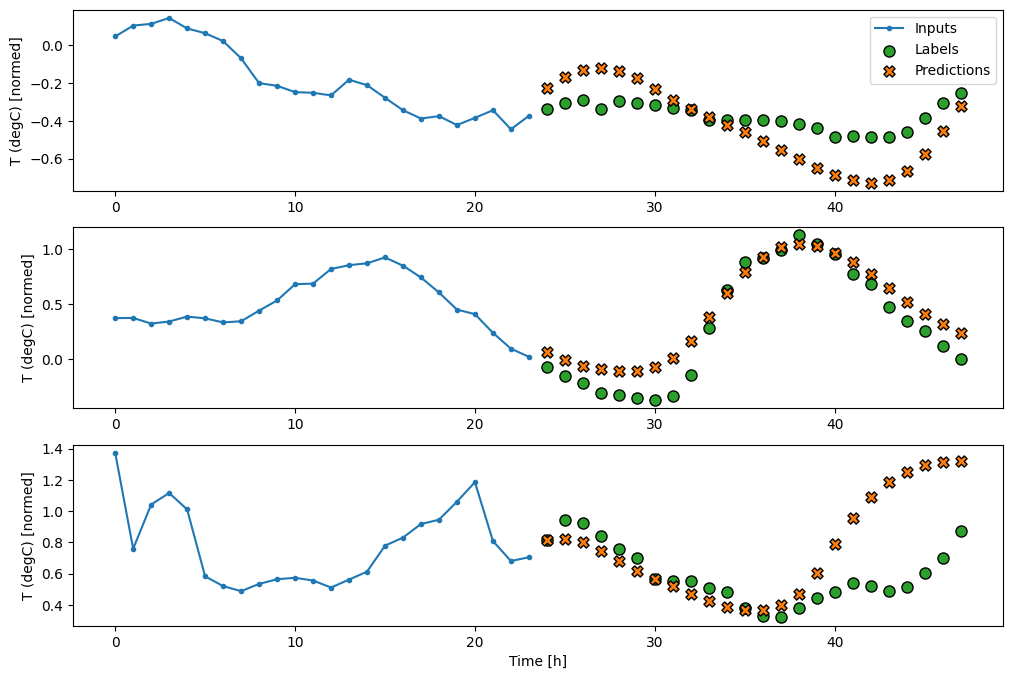

In [90]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### 性能

在这个问题上，作为模型复杂性的函数，返回值在明显递减。

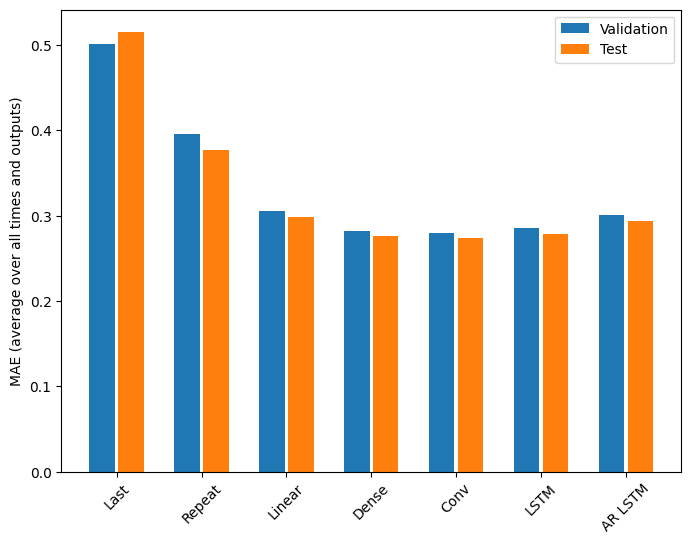

In [91]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

本教程前半部分的多输出模型的指标显示了所有输出特征的平均性能。这些性能类似，但在输出时间步骤上也进行了平均。 

In [92]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2982
Dense   : 0.2759
Conv    : 0.2742
LSTM    : 0.2779
AR LSTM : 0.2933


从密集模型到卷积模型和循环模型，所获得的增益只有百分之几（如果有的话），而自回归模型的表现显然更差。因此，在**这个**问题上使用这些更复杂的方法可能并不值得，但如果不尝试就无从知晓，而且这些模型可能会对**您的**问题有所帮助。

## 后续步骤

本教程是使用 TensorFlow 进行时间序列预测的简单介绍。

要了解更多信息，请参阅：

- <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>（第 2 版）第 15 章。
- [Python 深度学习](https://www.manning.com/books/deep-learning-with-python)第 6 章。
- <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity 的 Intro to TensorFlow for deep learning</a> 第 8 课，包括<a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">练习笔记本</a>。

还要记住，您可以在 TensorFlow 中实现任何<a href="https://otexts.com/fpp2/index.html" class="external">经典时间序列模型</a>，本教程仅重点介绍了 TensorFlow 的内置功能。
